In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%bash
wget https://raw.githubusercontent.com/Qsinap/Breast-cancer-segmentation/main/Codes/MultiResUNet.py
pip install keras==2.3.1
pip install tensorflow==2.2.0
pip install keras_applications==1.0.8
pip install image-classifiers==1.0.0
pip install efficientnet==1.0.0
pip install keras-unet
pip install tf-semantic-segmentation
pip install segmentation-models

In [ ]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [ ]:
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import math
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import scipy.io as sio
import pandas as pd
import seaborn as sns
import time
import MultiResUNet as multi
import cv2
import subprocess
import time

Using TensorFlow backend.


#Functions

In [ ]:
def plot_mamo(ima1,mas1):
  plt.figure(figsize=(15,7))
  plt.subplot(1,3,1)
  plt.imshow(ima1, cmap='gray')
  plt.axis('off')

  plt.subplot(1,3,2)
  plt.imshow(contour(ima1, mas1))
  plt.axis('off')

  plt.subplot(1,3,3)
  plt.imshow(mas1,cmap='hot')
  plt.axis('off')

In [ ]:
def superposition(hat, yt, num):
  base1=base2=np.zeros((256,256,3))
  base1[...,0]=hat[num][...,0]*255
  base1[...,2]=hat[num][...,0]*255

  base2[...,1]=yt[num][...,0]*255
  base2[...,2]=yt[num][...,0]*255

  return cv2.addWeighted(base1,0.5,base2,0.5,0)

In [ ]:
def contour(ima1, mas1):
  bina=((mas1!=0)*255).astype('uint8')
  cont,_=cv2.findContours(bina, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  rgb=cv2.cvtColor((ima1*255).astype('uint8'), cv2.COLOR_GRAY2BGR)
  dra=cv2.drawContours(rgb,cont, -1, (255,0,0),1)

  cmx=cmy=areac=0
  for x in cont:
    mm=cv2.moments(x)
    if mm['m00']>areac:
      areac=mm['m00']
      cmx=int(mm['m10']/mm['m00'])
      cmy=int(mm['m01']/mm['m00'])

  return dra, areac, cmx, cmy, cont

In [ ]:
def plot_threm(test, hat, yt, num=None):
  ran=25
  if num==None:
    num=np.random.choice(np.shape(hat)[0])
  draw, arex, cx, cy, cn=contour(test[num,:,:,0], yt[num,:,:,0])
  crry=0
  crrx=0
  if cy-ran<0:
    crry=cy-ran
  elif cy+ran>255:
    crry=cy+ran-255
  if cx-ran<0:
    crrx=cx-ran
  elif cx+ran>255:
    crrx=cx+ran-255
  draw=cv2.rectangle(draw, (cx-ran-crrx,cy-ran-crrx),(cx+ran-crry-1,cy+ran-crry-1),(0,125,255), 1)

  plt.figure(figsize=(20,8))
  plt.subplot(1,5,2)
  plt.imshow(draw[cy-ran-crry:cy+ran-crry, cx-ran-crrx:cx+ran-crrx])#test[num])
  plt.axis('off')
  plt.title('ROI')

  draw=cv2.rectangle(draw, (cx-ran-crrx,cy-ran-crrx),(cx+ran-crry-1,cy+ran-crry-1),(0,125,255), 3)
  draw=cv2.drawContours(draw,cn, -1, (255,0,0),2)

  plt.subplot(1,5,1)
  plt.imshow(draw)#test[num])
  plt.axis('off')
  plt.title('Mammography')

  plt.subplot(1,5,3)
  plt.imshow(yt[num][...,0][cy-ran-crry:cy+ran-crry, cx-ran-crrx:cx+ran-crrx], cmap='gray')
  plt.axis('off')
  plt.title('Ground Truth')

  plt.subplot(1,5,4)
  plt.imshow(hat[num][...,0][cy-ran-crry:cy+ran-crry, cx-ran-crrx:cx+ran-crrx], cmap='hot')
  plt.axis('off')
  plt.title('Prediction')
  
  plt.subplot(1,5,5)
  plt.imshow(superposition(hat, yt, num)[cy-ran-crry:cy+ran-crry, cx-ran-crrx:cx+ran-crrx])
  plt.axis('off')
  plt.title('overlap')
  plt.subplots_adjust(wspace=0.03)
  print(num)

In [ ]:
def w_gpu():
  try:
    output = str(subprocess.check_output("nvidia-smi --query-gpu=gpu_name --format=csv", shell=True))
  except:
    output=' None '
  gpu=output[output.find('\\n')+2: output.rfind('\\n')]
  return gpu

In [ ]:
def save_csv(netw, size, tictoc):
  times=pd.read_csv('/content/drive/MyDrive/INDIGO_MLR/CancerDeMama/figures/TIMES.csv')
  times=times.append({'Network': netw, 
                      'GPU': w_gpu(),
                      'Number of subjects':size[0],
                      'Total time': tictoc,
                      'Time per subject': tictoc/size[0]}, ignore_index=True)
  times=times.drop(times.columns[:np.where(times.columns=='Network')[0][0]], axis=1) 
  times.to_csv('/content/drive/MyDrive/INDIGO_MLR/CancerDeMama/figures/TIMES.csv')

In [ ]:
def test_model(df, net='none'):
  try:
    del model
  except:
    print('...')

  if net=='none':
    dafra=df
    base='unet'
  else:
    dafra=df.loc[df['network']==net]
    base=net[:net.find('_')] 
  p=len(base)+1
  ind=np.where(dafra['dice_coef']==np.max(dafra['dice_coef']))[0][0]
  print(dafra.iloc[ind])
  model=read_model(base, dafra.iloc[ind]['network'][p:])
  model.load_weights(pathw+dafra.iloc[ind]['result_mat'][:-6]+'w.h5')

  tic=time.time()
  yxx=model.predict(x_test)
  toc=time.time()

  save_csv(net, np.shape(x_test), toc-tic)

  return yxx

In [ ]:
def plot_trainings(netw, rang=0.6, ele='dice_coef', title=''):
  sns.set_theme(style="darkgrid")
  plt.figure(figsize=(24,10))
  xt=[]
  yt=[]
  lost=[]
  for k in range(5):
    mats=glob.glob(base.format(network=netw, loss=n_losses[k]))
    x=[]
    y=[]
    los=[]
    for i in mats:
      uno=sio.loadmat(i)[ele][0]
      x=np.append(x, np.arange(150))
      y=np.append(y, uno)
      los=np.append(los, [n_losses[k] for d in range(150)])

      xt=np.append(xt, np.arange(150))
      yt=np.append(yt, uno)
      lost=np.append(lost, [n_losses[k] for d in range(150)])


    dg=pd.DataFrame({'x':x,'y':y, 'loss':los})
    plt.subplot(2,3,k+1)
    sns.lineplot(x="x", y="y", hue='loss', data=dg)
    plt.ylabel(ele)
    plt.xlabel('Epoch')
    plt.title(title)
    plt.ylim(rang, 1)

  dgt=pd.DataFrame({'x':xt,'y':yt, 'loss':lost})
  plt.subplot(2,3,6)
  sns.lineplot(x="x", y="y", hue='loss', data=dgt)
  plt.ylabel(ele)
  plt.title(title)
  plt.xlabel('Epoch')

  plt.ylim(rang, 1)
  return dgt

In [ ]:
from keras_unet.models import custom_unet
from segmentation_models import Unet, Linknet, FPN, PSPNet

def read_model(net, back, inputshape=(256,256,3)):
  not_p=True
  if net=='multiresunet':
    model=multi.MultiResUnet(256,256,3)
    not_p=False
  
  if net=='link':
    model=Linknet(back, inputshape)
    not_p=False
  
  if net=='unet':
    model=Unet(back, inputshape)
    not_p=False

  if net=='Base':
    model=custom_unet(inputshape)
    not_p=False

  if not_p:
    print('Network name does not exist')

  return model

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------
Segmentation Models: using `tf.keras` framework.


In [ ]:
backbones=['efficientnetb7', 'inceptionresnetv2','resnet152', 'resnext101', 'seresnext101', 'seresnet152', 'densenet201', 'mobilenetv2', 'vgg19']
net=['unet', 'multiresunet', 'link', 'Base']

In [ ]:
layers=['.convolutional.', 'Conv2D ',  'Conv2DTranspose', 'UpSampling2D', 'DepthwiseConv2D','pooling', 'normalization', 'Concatenate', 'merge.Add']
def structure_model(model):
  n_lay=[]

  for j in layers:
    contl=0
    for i in model.layers:
      indconv=str(i).find(j)
      if indconv!=-1:
        contl=contl+1
    n_lay=np.append(n_lay,contl)
  return n_lay

In [ ]:
 for nx in net:
   if nx=='unet':
     for bk in backbones:
       model=read_model(nx, bk)
       print(nx, bk)
       print(structure_model(model))
   else:
     model=read_model(nx, 'vgg19')
     print(nx)
     print(structure_model(model))

unet efficientnetb7
[289. 284.   0.   5.  55.  55. 173.   4.  48.]
unet inceptionresnetv2
[260. 255.   0.   5.   0.   5. 214.  47.   0.]
unet resnet152
[223. 166.   0.   5.   0.   1. 163.   4.  50.]
unet resnext101
[1.178e+03 1.138e+03 0.000e+00 5.000e+00 0.000e+00 1.000e+00 1.150e+02
 3.700e+01 3.300e+01]
unet seresnext101
[1244. 1204.    0.    5.    0.   34.  114.   37.   33.]
unet seresnet152
[323. 266.   0.   5.   0.  51. 165.   4.  50.]
unet densenet201
[218. 211.   0.   5.   0.   4. 211. 102.   0.]


/usr/local/lib/python3.7/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


unet mobilenetv2
[73. 63.  0.  5. 17.  0. 62.  4. 10.]
unet vgg19
[34. 29.  0.  5.  0.  5. 12.  4.  0.]
multiresunet
[61. 57.  4.  0.  0.  4. 85. 13. 19.]
link
[39. 34.  0.  5.  0.  5. 17.  0.  4.]
Base
[23. 19.  4.  0.  0.  4. 18.  4.  0.]


#Results

In [ ]:
path='/content/drive/MyDrive/INDIGO_MLR/CancerDeMama/'
pathw=path+'weights/'
fig=path+'figures/'

In [ ]:
df = pd.DataFrame(columns=('tumor_type','run_n', 'network', 'optimizer', 'loss', 'epochs', 'total_parameters', 'time','augm', 'jaccard_distances', 'acc','sensitivity','specificity','FPR','dice_coef', 'result_mat'))
df.head()

Empty DataFrame
Columns: [tumor_type, run_n, network, optimizer, loss, epochs, total_parameters, time, augm, jaccard_distances, acc, sensitivity, specificity, FPR, dice_coef, result_mat]
Index: []

In [ ]:
csvs=glob.glob(path+'*.csv')
print(np.shape(csvs))

(13,)


In [ ]:
for name_c in csvs:
  csv=pd.read_csv(name_c)
  csv=csv.drop(csv.columns[:np.where(csv.columns=='tumor_type')[0][0]], axis=1)  
  df=df.append(csv, ignore_index=True)

In [ ]:
df[["network", "acc", "dice_coef", "sensitivity", "specificity"]].groupby("network").describe().sort_values(by=[('dice_coef',   'max')], ascending=False)

acc                      ... specificity                    
                       count      mean       std  ...         50%       75%       max
network                                           ...                                
unet_efficientnetb7     20.0  0.999010  0.000537  ...    0.999711  0.999818  0.999928
unet_inceptionresnetv2  21.0  0.998674  0.000711  ...    0.999436  0.999810  0.999906
unet_resnet152          21.0  0.998406  0.000736  ...    0.999602  0.999790  0.999917
unet_resnext101         20.0  0.998349  0.000903  ...    0.999447  0.999823  0.999883
unet_seresnet152        18.0  0.998611  0.000682  ...    0.999583  0.999803  0.999909
unet_seresnext101       10.0  0.998657  0.000572  ...    0.999543  0.999778  0.999854
unet_densenet201        20.0  0.998024  0.000971  ...    0.999439  0.999766  0.999879
unet_mobilenetv2        22.0  0.998368  0.000567  ...    0.999579  0.999710  0.999871
multiresunet_vgg19       8.0  0.998681  0.000566  ...    0.999735  0.999850  0.999887
link_vgg19              22.0  0.994851  0.010418  ...    0.999706  0.999913  1.000000
unet_vgg19              20.0  0.997870  0.001111  ...    0.999685  0.999841  1.000000
Base_unet_None          20.0  0.997723  0.001012  ...    0.999277  0.999643  0.999908

[12 rows x 32 columns]

In [ ]:
df[["loss", "acc", "dice_coef", "sensitivity", "specificity"]].groupby("loss").describe().sort_values(by=[('dice_coef',   'max')], ascending=False)

acc            ... specificity          
                           count      mean  ...         75%       max
loss                                        ...                      
binary_crossentropy         51.0  0.998922  ...    0.999809  1.000000
weighted_cross_entropyloss  42.0  0.999051  ...    0.999903  1.000000
tversky_loss                41.0  0.996734  ...    0.999338  0.999604
dice_coef_loss              45.0  0.997550  ...    0.999661  1.000000
log_cosh_dice_loss          43.0  0.997652  ...    0.999514  1.000000

[5 rows x 32 columns]

In [ ]:
df[["network", "time"]].groupby("network").describe().sort_values(by=[('time',   'mean')])

time             ...                      
                       count       mean  ...        75%        max
network                                  ...                      
link_vgg19              22.0   1.752146  ...   1.698776   4.860028
Base_unet_None          20.0   2.758739  ...   0.932531  37.014106
unet_mobilenetv2        22.0   3.522638  ...   3.425661   6.816293
unet_vgg19              20.0   3.532217  ...   1.795602  36.009428
multiresunet_vgg19       8.0   5.029590  ...   5.407683   5.455797
unet_densenet201        20.0  11.731105  ...  13.014517  15.331373
unet_resnet152          21.0  12.236382  ...  13.600960  23.528564
unet_inceptionresnetv2  21.0  13.966548  ...  15.422753  21.000547
unet_efficientnetb7     20.0  17.400244  ...  18.565767  28.453001
unet_seresnet152        18.0  17.424896  ...  20.452764  26.842413
unet_resnext101         20.0  23.159403  ...  26.090899  28.742102
unet_seresnext101       10.0  26.111378  ...  27.952151  34.107489

[12 rows x 8 columns]

In [ ]:
df[["network", "total_parameters"]].groupby("network").max().sort_values(by='total_parameters')

total_parameters
network                                 
Base_unet_None                   1945521
multiresunet_vgg19               7262750
unet_mobilenetv2                 8047441
link_vgg19                      25634833
unet_densenet201                26378577
unet_vgg19                      29061969
unet_resnext101                 51281626
unet_seresnext101               56059329
unet_inceptionresnetv2          62061553
unet_resnet152                  67295194
unet_seresnet152                73939329
unet_efficientnetb7             75048097

#Dataset

In [ ]:
datos=sio.loadmat(path+'/data.mat')
images=datos['images'].astype('float32')
masks=(datos['masks']!=0).astype('float32')
n_ima,row,cols=np.shape(images)
images=images.reshape((*images.shape,1))
masks=masks.reshape((*masks.shape,1))
del datos

In [ ]:
imagesRGB=np.zeros((n_ima, row, cols, 3))
imagesRGB[...,0]=imagesRGB[...,1]=imagesRGB[...,2]=images[...,0]
images=imagesRGB
del imagesRGB

In [ ]:
sp,sp2 = int(n_ima*0.8), int(n_ima*0.7)
x_test, x_train, x_val=images[sp:], images[:sp2], images[sp2:sp]
y_test, y_train, y_val=masks[sp:], masks[:sp2], masks[sp2:sp]
print(np.shape(x_test), np.shape(x_train), np.shape(x_val))
del images, masks

(143, 256, 256, 3) (499, 256, 256, 3) (72, 256, 256, 3)


#Networks

In [ ]:
y_hat=test_model(df)

...
tumor_type                                                         NaN
run_n                                                                2
network                                            unet_efficientnetb7
optimizer                                                         Adam
loss                                               binary_crossentropy
epochs                                                             150
total_parameters                                              75048097
time                                                           15.4186
augm                                                                 8
jaccard_distances                                          0.000515627
acc                                                           0.999573
sensitivity                                                   0.952149
specificity                                                   0.999811
FPR                                                        0.000189364
di

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24


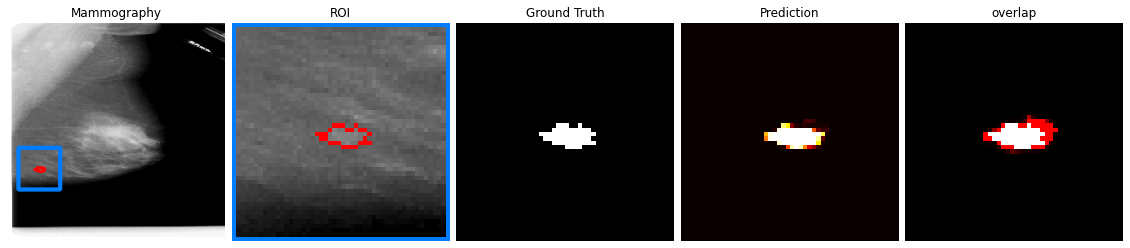

In [ ]:
plot_threm(x_test, y_hat, y_test, 24)#24,70 - 67
plt.savefig(fig+'efficientnet-24.svg')

In [ ]:
y_hat=test_model(df, 'unet_inceptionresnetv2')

...
tumor_type                                                         NaN
run_n                                                                5
network                                         unet_inceptionresnetv2
optimizer                                                         Adam
loss                                               binary_crossentropy
epochs                                                             150
total_parameters                                              62061553
time                                                           11.5647
augm                                                                 8
jaccard_distances                                          0.000582999
acc                                                           0.999496
sensitivity                                                    0.94233
specificity                                                   0.999782
FPR                                                        0.000217915
di

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


67


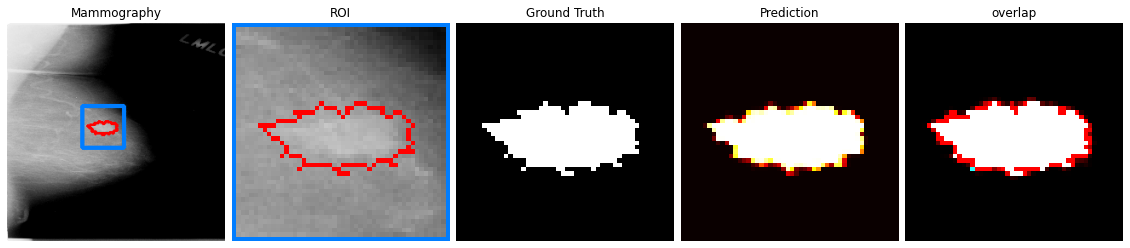

In [ ]:
plot_threm(x_test, y_hat, y_test, 67)
plt.savefig(fig+'inceptionresnetv2-67.svg')

In [ ]:
y_hat=test_model(df, 'unet_resnet152')

...
tumor_type                                                         NaN
run_n                                                                0
network                                                 unet_resnet152
optimizer                                                         Adam
loss                                               binary_crossentropy
epochs                                                             150
total_parameters                                              67295194
time                                                           17.0215
augm                                                                 8
jaccard_distances                                          0.000623542
acc                                                           0.999455
sensitivity                                                   0.932533
specificity                                                    0.99979
FPR                                                        0.000209987
di

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


67


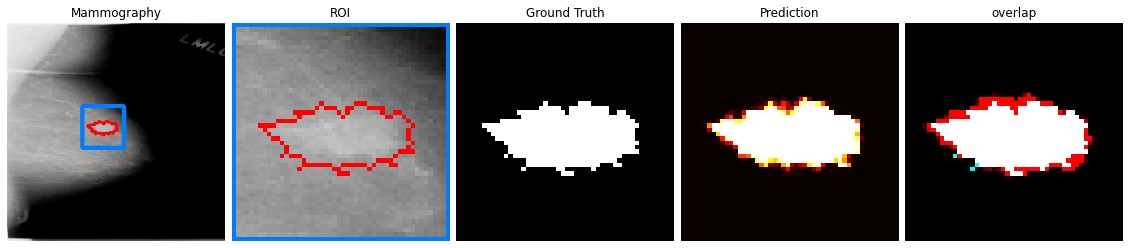

In [ ]:
plot_threm(x_test, y_hat, y_test,67)
plt.savefig(fig+'resnet152-67.svg')

In [ ]:
y_hat=test_model(df, 'unet_densenet201')

...
tumor_type                                                         NaN
run_n                                                                0
network                                               unet_densenet201
optimizer                                                         Adam
loss                                               binary_crossentropy
epochs                                                             150
total_parameters                                              26378577
time                                                           11.0827
augm                                                                 8
jaccard_distances                                          0.000696492
acc                                                           0.999379
sensitivity                                                   0.915446
specificity                                                   0.999799
FPR                                                        0.000201404
di

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


67


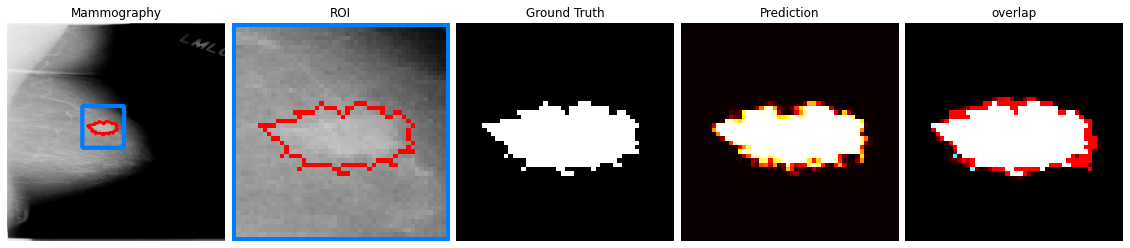

In [ ]:
plot_threm(x_test, y_hat, y_test, 67)
plt.savefig(fig+'densenet201-67.svg')

In [ ]:
y_hat=test_model(df, 'unet_mobilenetv2')

...
tumor_type                                                         NaN
run_n                                                                4
network                                               unet_mobilenetv2
optimizer                                                         Adam
loss                                               binary_crossentropy
epochs                                                             150
total_parameters                                               8047441
time                                                           2.76398
augm                                                                 8
jaccard_distances                                           0.00091285
acc                                                           0.999219
sensitivity                                                   0.901854
specificity                                                   0.999706
FPR                                                         0.00029403
di

/usr/local/lib/python3.7/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 0s 0us/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


67


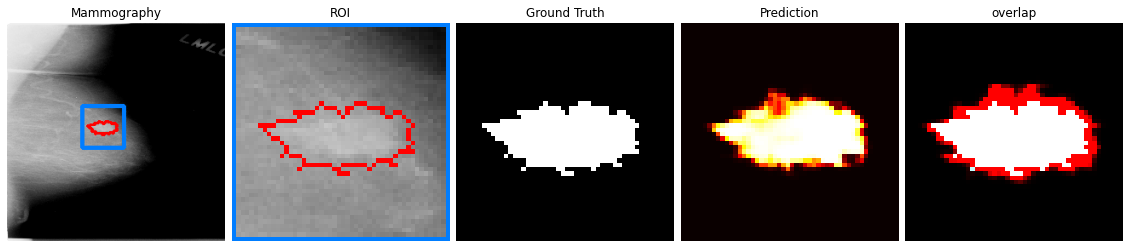

In [ ]:
plot_threm(x_test, y_hat, y_test, 67)
plt.savefig(fig+'mobilenetv2-67.svg')

In [ ]:
y_hat=test_model(df, 'unet_vgg19')

...
tumor_type                                                         NaN
run_n                                                                0
network                                                     unet_vgg19
optimizer                                                         Adam
loss                                        weighted_cross_entropyloss
epochs                                                             150
total_parameters                                              29061969
time                                                           0.97028
augm                                                                 8
jaccard_distances                                           0.00121273
acc                                                           0.998861
sensitivity                                                   0.794683
specificity                                                   0.999883
FPR                                                        0.000117302
di

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


67


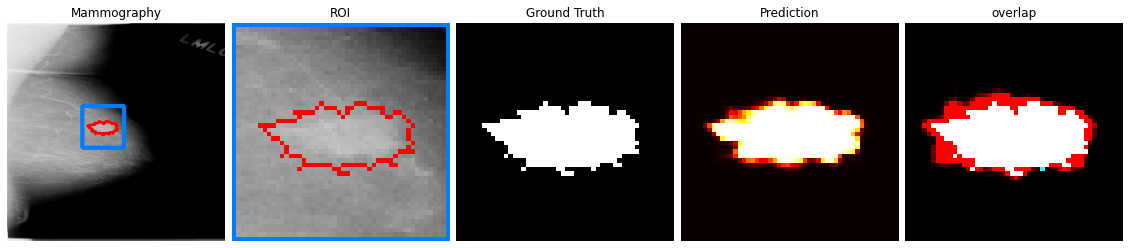

In [ ]:
plot_threm(x_test, y_hat, y_test, 67)
plt.savefig(fig+'unet_vgg19-67.svg')

In [ ]:
y_hat=test_model(df, 'multiresunet_vgg19')

...
tumor_type                                                         NaN
run_n                                                                2
network                                             multiresunet_vgg19
optimizer                                                         Adam
loss                                               binary_crossentropy
epochs                                                             150
total_parameters                                               7262750
time                                                            4.9581
augm                                                                 8
jaccard_distances                                          0.000950669
acc                                                           0.999434
sensitivity                                                   0.908758
specificity                                                   0.999887
FPR                                                        0.000112951
di

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


67


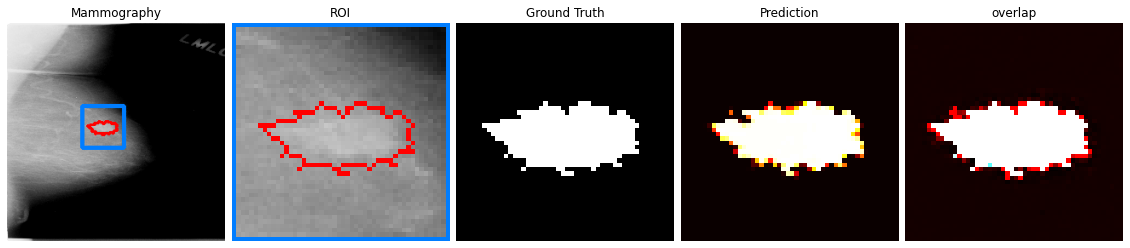

In [ ]:
plot_threm(x_test, y_hat, y_test, 67)
plt.savefig(fig+'multiresunet_67.svg')

In [ ]:
y_hat=test_model(df, 'link_vgg19')

...
tumor_type                                                         NaN
run_n                                                                0
network                                                     link_vgg19
optimizer                                                         Adam
loss                                               binary_crossentropy
epochs                                                             150
total_parameters                                              25634833
time                                                           4.86003
augm                                                                 8
jaccard_distances                                          0.000954136
acc                                                           0.999133
sensitivity                                                   0.872612
specificity                                                   0.999766
FPR                                                         0.00023365
di

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


67


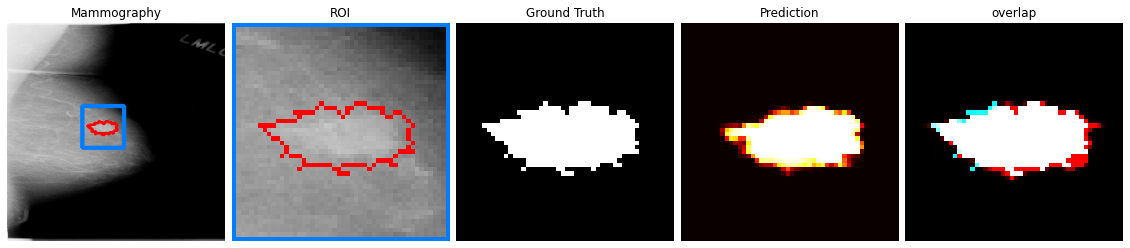

In [ ]:
plot_threm(x_test, y_hat, y_test, 67)
plt.savefig(fig+'link_vgg19-67.svg')

In [ ]:
y_hat=test_model(df, 'unet_seresnext101')

...
tumor_type                                                         NaN
run_n                                                               20
network                                              unet_seresnext101
optimizer                                                         Adam
loss                                        weighted_cross_entropyloss
epochs                                                             150
total_parameters                                              56059329
time                                                           25.4871
augm                                                                 8
jaccard_distances                                           0.00069209
acc                                                           0.999357
sensitivity                                                   0.914932
specificity                                                    0.99978
FPR                                                        0.000220239
di

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


67


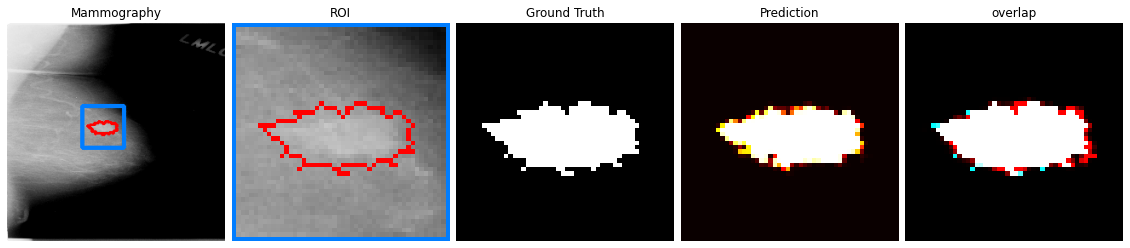

In [ ]:
plot_threm(x_test, y_hat, y_test, 67)
plt.savefig(fig+'seresnext101-67.svg')

In [ ]:
y_hat=test_model(df, 'unet_seresnet152')

...
tumor_type                                                         NaN
run_n                                                               12
network                                               unet_seresnet152
optimizer                                                         Adam
loss                                               binary_crossentropy
epochs                                                             150
total_parameters                                              73939329
time                                                           26.8424
augm                                                                 8
jaccard_distances                                          0.000661114
acc                                                           0.999425
sensitivity                                                   0.927045
specificity                                                   0.999787
FPR                                                        0.000213325
di

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


67


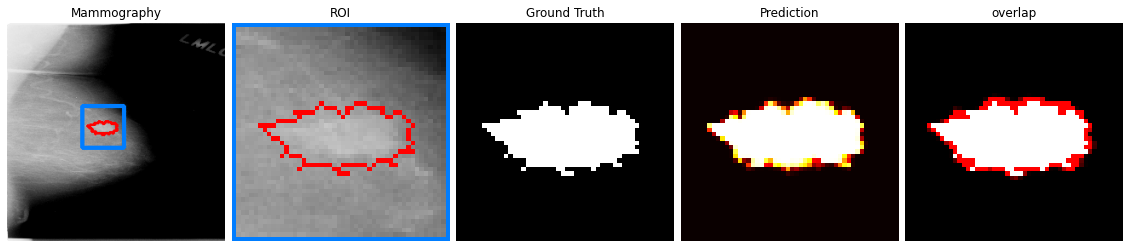

In [ ]:
plot_threm(x_test, y_hat, y_test, 67)
plt.savefig(fig+'seresnet152-67.svg')

In [ ]:
y_hat=test_model(df, 'unet_resnext101')

...
tumor_type                                                         NaN
run_n                                                               10
network                                                unet_resnext101
optimizer                                                         Adam
loss                                               binary_crossentropy
epochs                                                             150
total_parameters                                              51281626
time                                                           24.5389
augm                                                                 8
jaccard_distances                                          0.000634685
acc                                                           0.999452
sensitivity                                                   0.936692
specificity                                                   0.999766
FPR                                                        0.000234425
di

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


67


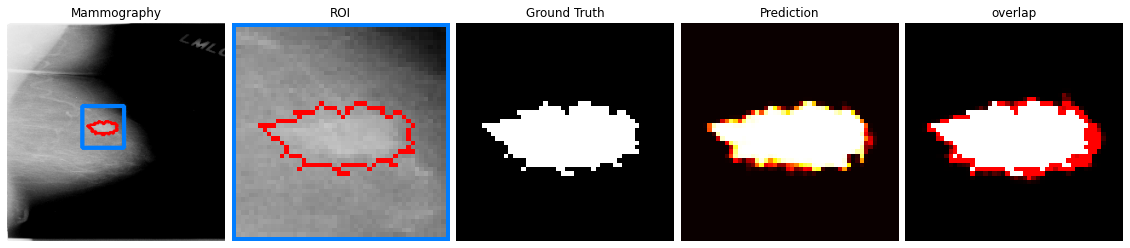

In [ ]:
plot_threm(x_test, y_hat, y_test, 67)
plt.savefig(fig+'resnext101-67.svg')

In [ ]:
y_hat=test_model(df, 'Base_unet_None')

...
tumor_type                                                         NaN
run_n                                                               11
network                                                 Base_unet_None
optimizer                                                         Adam
loss                                        weighted_cross_entropyloss
epochs                                                             150
total_parameters                                               1945521
time                                                          0.895547
augm                                                                 8
jaccard_distances                                           0.00122883
acc                                                           0.998957
sensitivity                                                   0.814257
specificity                                                   0.999881
FPR                                                        0.000118613
di

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


67


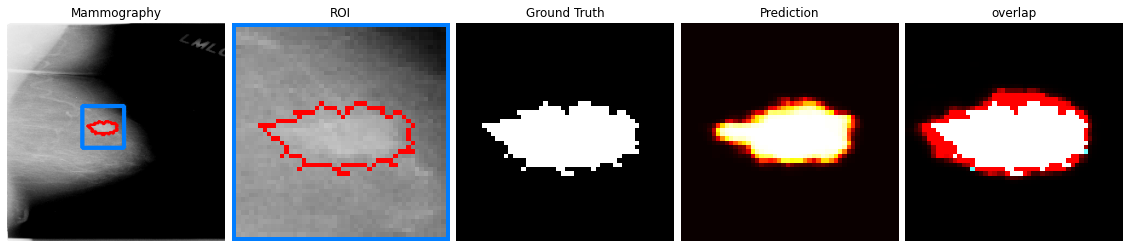

In [ ]:
plot_threm(x_test, y_hat, y_test, 67)
plt.savefig(fig+'base_unet-67.svg')

In [ ]:
!zip 67.zip /content/drive/MyDrive/INDIGO_MLR/CancerDeMama/figures/*67.svg

  adding: content/drive/MyDrive/INDIGO_MLR/CancerDeMama/figures/base_unet-67.svg (deflated 41%)
  adding: content/drive/MyDrive/INDIGO_MLR/CancerDeMama/figures/densenet201-67.svg (deflated 41%)
  adding: content/drive/MyDrive/INDIGO_MLR/CancerDeMama/figures/efficientnet-67.svg (deflated 41%)
  adding: content/drive/MyDrive/INDIGO_MLR/CancerDeMama/figures/inceptionresnetv2-67.svg (deflated 41%)
  adding: content/drive/MyDrive/INDIGO_MLR/CancerDeMama/figures/link_vgg19-67.svg (deflated 41%)
  adding: content/drive/MyDrive/INDIGO_MLR/CancerDeMama/figures/mobilenetv2-67.svg (deflated 41%)
  adding: content/drive/MyDrive/INDIGO_MLR/CancerDeMama/figures/multiresunet_67.svg (deflated 40%)
  adding: content/drive/MyDrive/INDIGO_MLR/CancerDeMama/figures/resnet152-67.svg (deflated 41%)
  adding: content/drive/MyDrive/INDIGO_MLR/CancerDeMama/figures/resnext101-67.svg (deflated 41%)
  adding: content/drive/MyDrive/INDIGO_MLR/CancerDeMama/figures/seresnet152-67.svg (deflated 41%)
  adding: content/

In [ ]:
from keras_unet.models import custom_unet
from segmentation_models import Unet, Linknet, FPN, PSPNet

def read_model(net, back, inputshape=(256,256,3)):
  not_p=True
  if net=='multiresunet':
    model=multi.MultiResUnet(256,256,3)
    not_p=False
  
  if net=='link':
    model=Linknet(back, inputshape)
    not_p=False
  
  if net=='unet':
    model=Unet(back, inputshape)
    not_p=False

  if net=='Base':
    model=custom_unet(inputshape)
    not_p=False

  if not_p:
    print('Network name does not exist')

  return model

In [ ]:
backbones=['efficientnetb7', 'inceptionresnetv2','resnet152', 'resnext101', 'seresnext101', 'seresnet152', 'densenet201', 'mobilenetv2', 'vgg19']
net=['unet', 'multiresunet', 'link', 'Base']

In [ ]:
 for nx in net:
   if nx=='unet':
     for bk in backbones:
       model=read_model(nx, bk)
       print(nx, bk)
       print(np.shape(model.trainable_weights))
   else:
     model=read_model(nx, 'vgg19')
     print(nx)
     print(np.shape(model.trainable_weights)) 

### Trainings

In [ ]:
base='/content/drive/MyDrive/INDIGO_MLR/CancerDeMama/weights/breast_cancer__{network}_Adam_{loss}_run_*_r.mat'
n_losses=['binary_crossentropy', 'weighted_cross_entropyloss', 'tversky_loss', 'dice_coef_loss', 'log_cosh_dice_loss']
keys=['loss', 'acc', 'jaccard_distance', 'dice_coef', 'val_loss', 'val_acc', 'val_jaccard_distance', 'val_dice_coef']

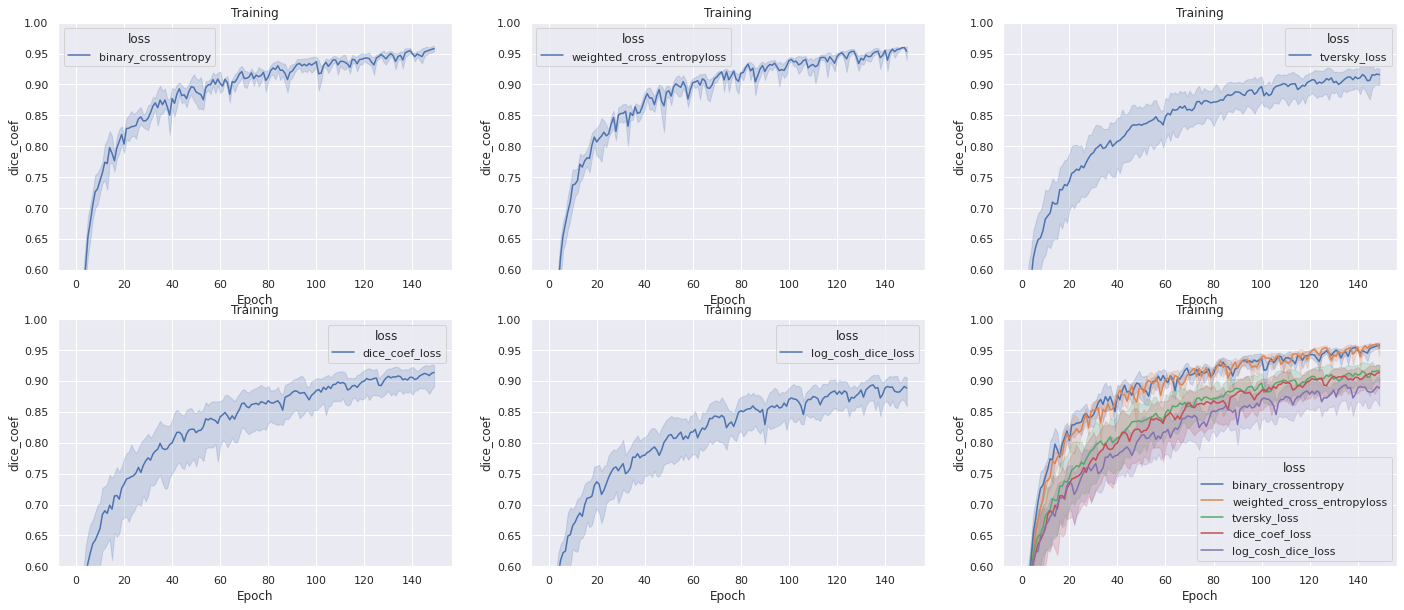

In [ ]:
frame=plot_trainings('unet_efficientnetb7', title='Training')
plt.savefig(fig+'Training-efficientnet.svg')

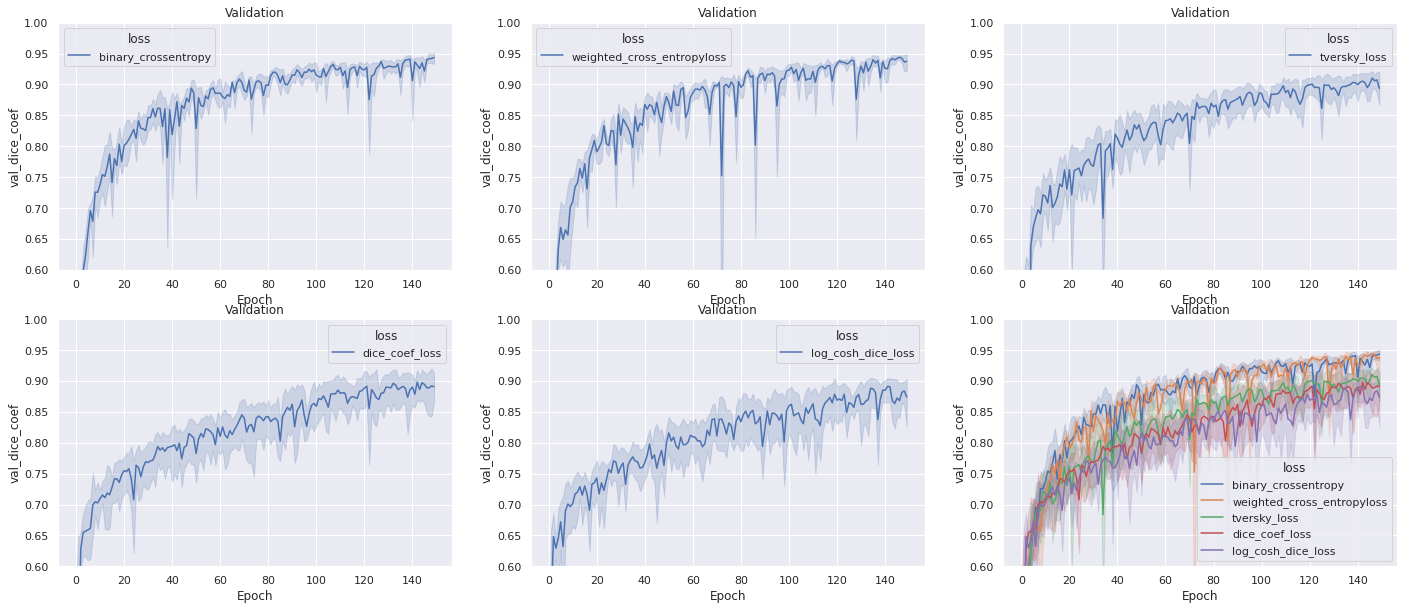

In [ ]:
frame=plot_trainings('unet_efficientnetb7', ele='val_dice_coef', title='Validation')
plt.savefig(fig+'Validation-efficientnet.svg')

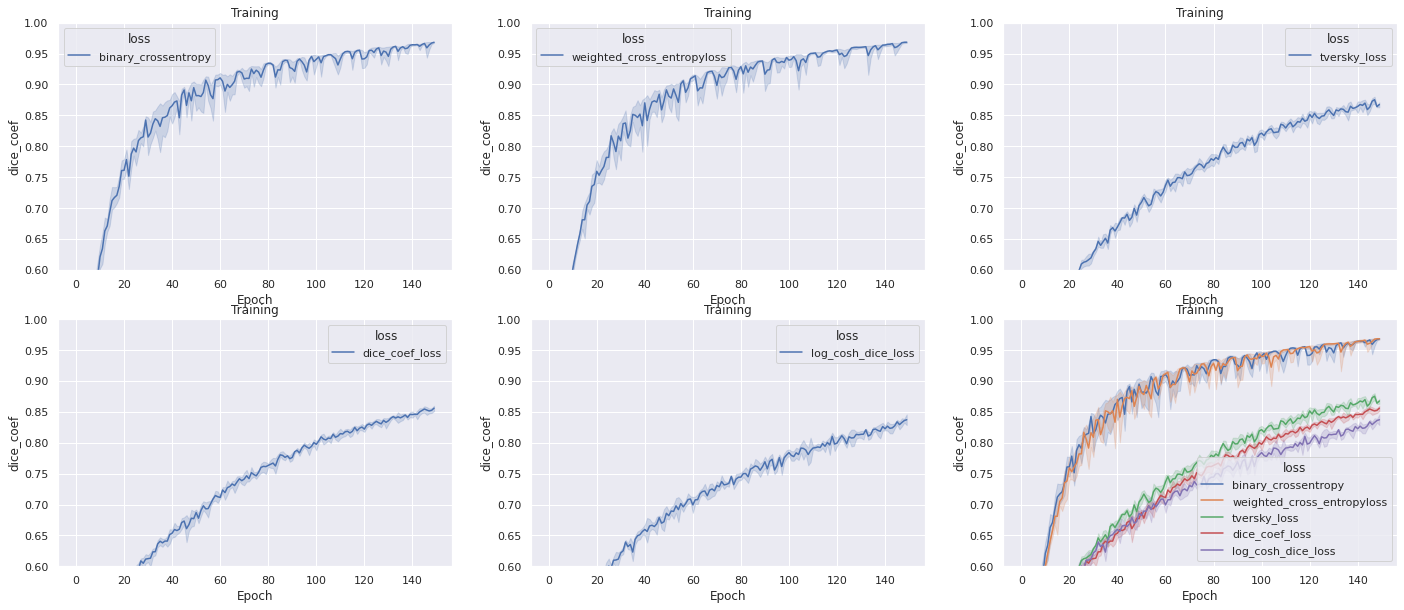

In [ ]:
frame=plot_trainings('unet_inceptionresnetv2', title='Training')
plt.savefig(fig+'Training-inceptionresnetv2.svg')

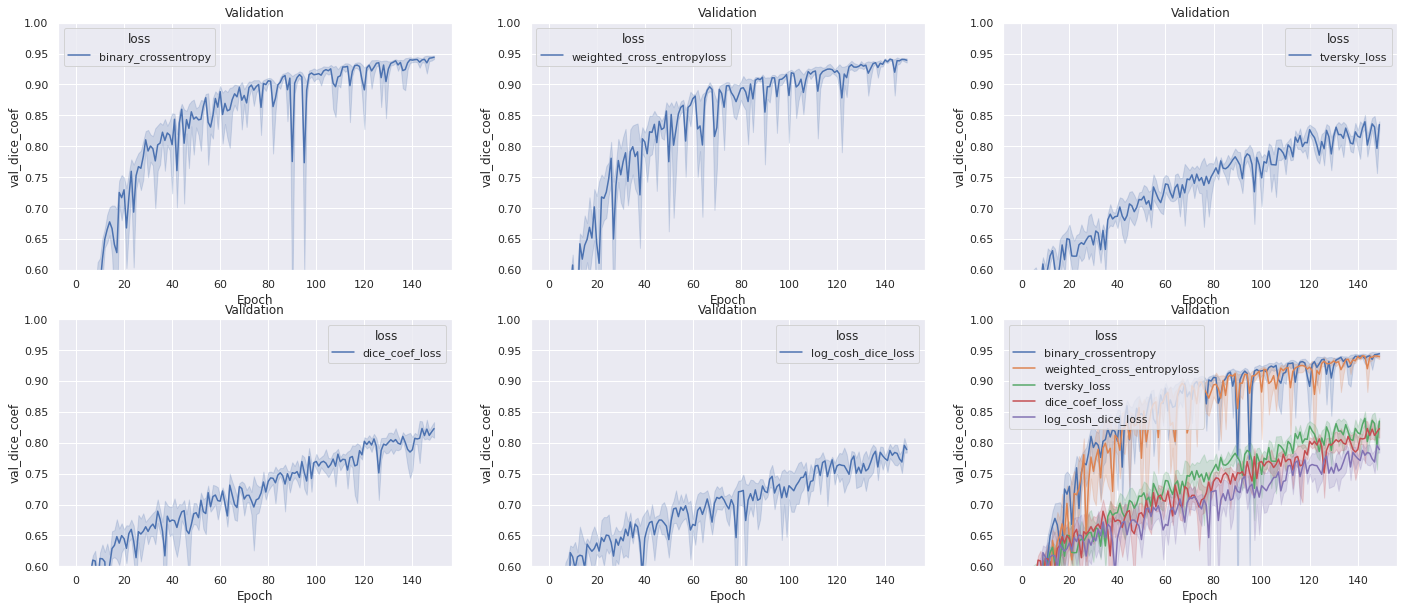

In [ ]:
frame=plot_trainings('unet_inceptionresnetv2', ele='val_dice_coef', title='Validation')
plt.savefig(fig+'Validation-inceptionresnetv2.svg')

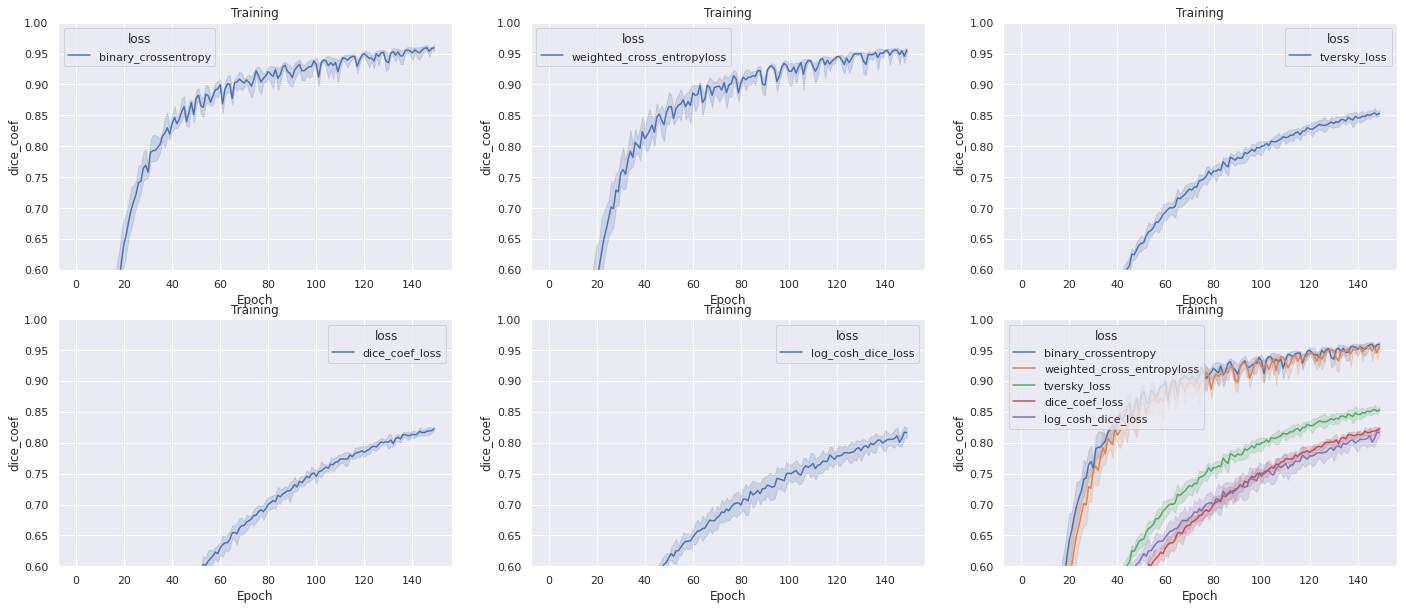

In [ ]:
frame=plot_trainings('unet_resnet152', title='Training')
plt.savefig(fig+'Training-resnet152.svg')

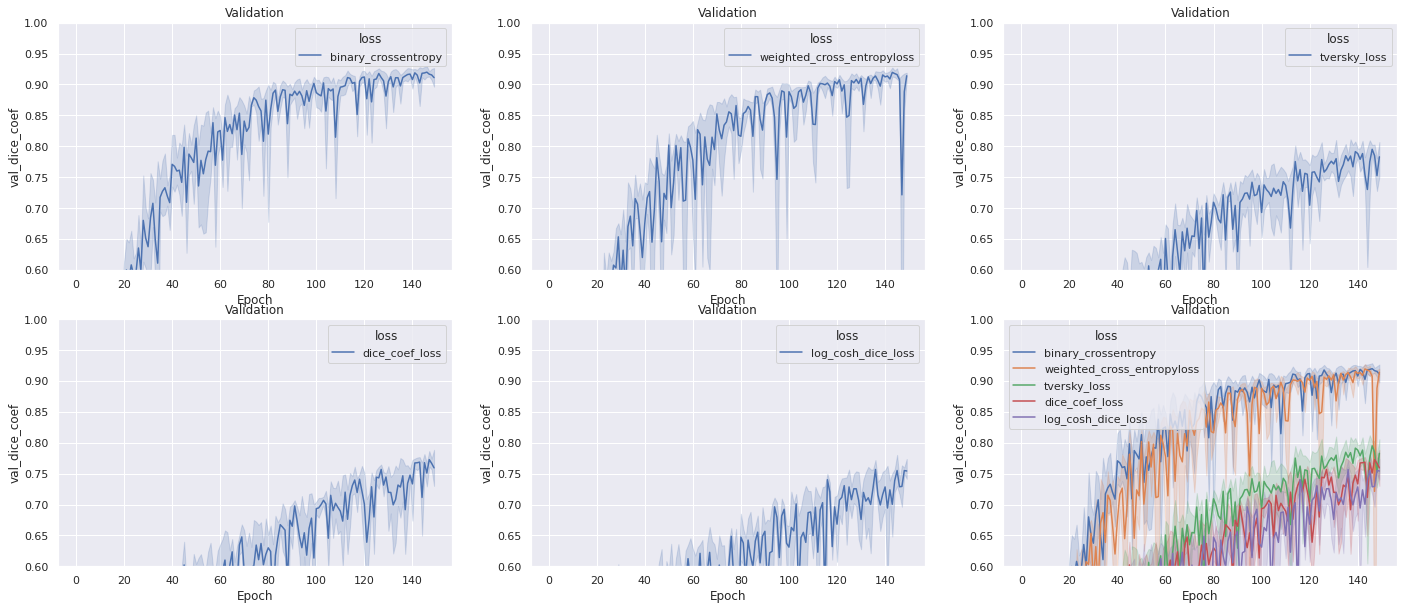

In [ ]:
frame=plot_trainings('unet_resnet152', ele='val_dice_coef', title='Validation')
plt.savefig(fig+'Validation-resnet152.svg')

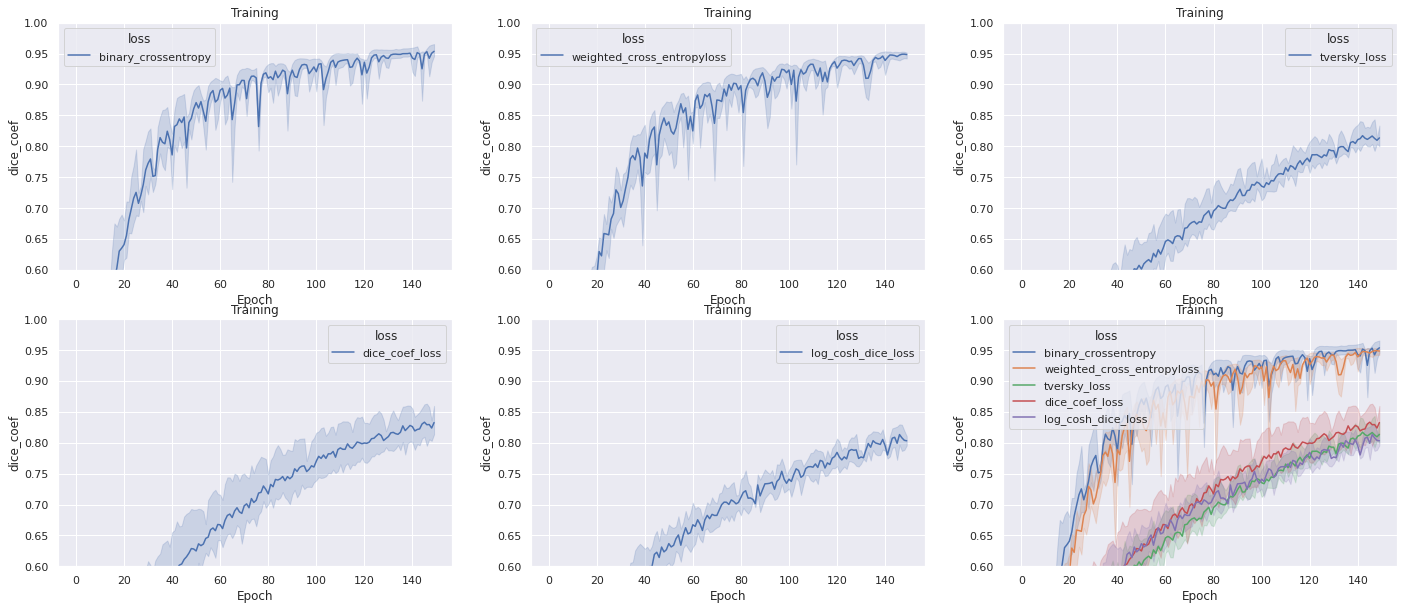

In [ ]:
frame=plot_trainings('unet_densenet201', title='Training')
plt.savefig(fig+'Training-densenet201.svg')

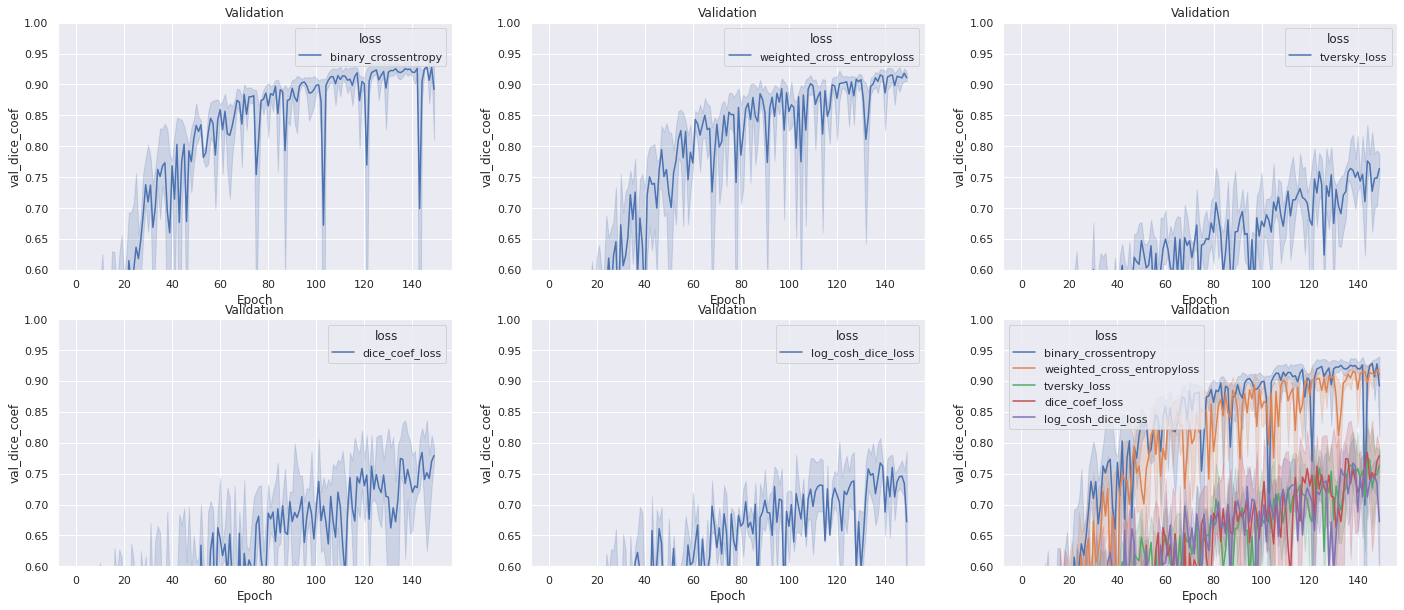

In [ ]:
frame=plot_trainings('unet_densenet201', ele='val_dice_coef', title='Validation')
plt.savefig(fig+'Validation-densenet201.svg')

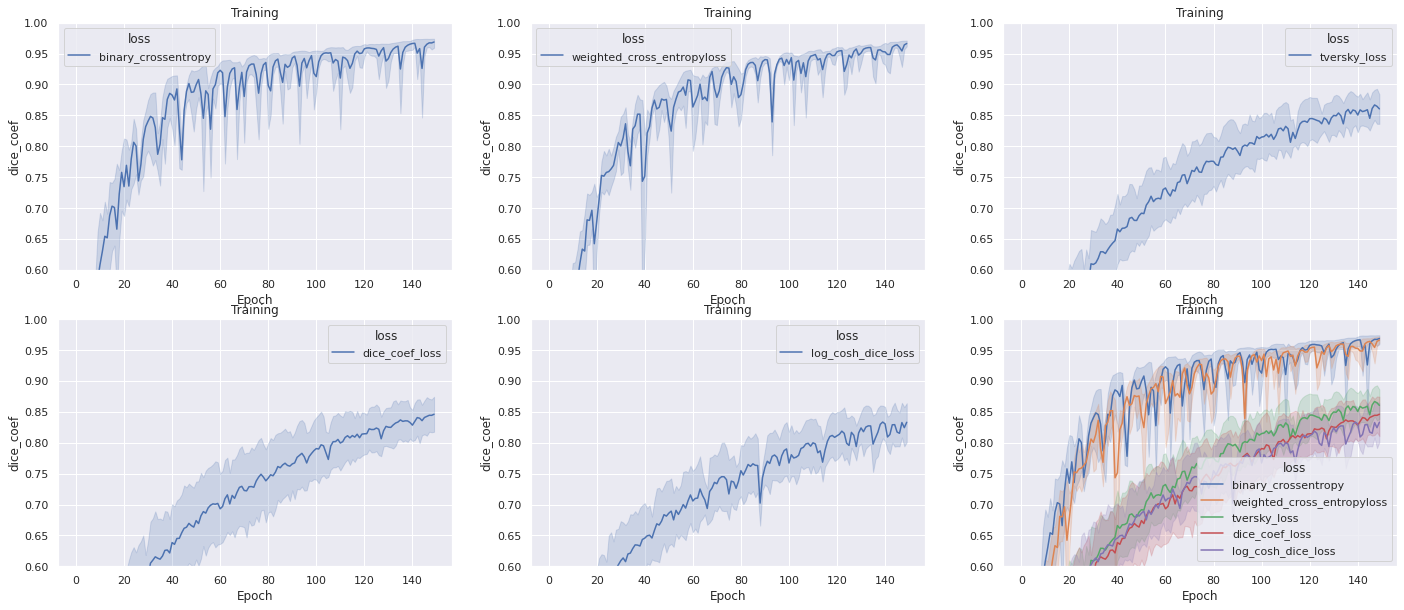

In [ ]:
frame=plot_trainings('unet_resnext101', title='Training')
plt.savefig(fig+'Training-resnext101.svg')

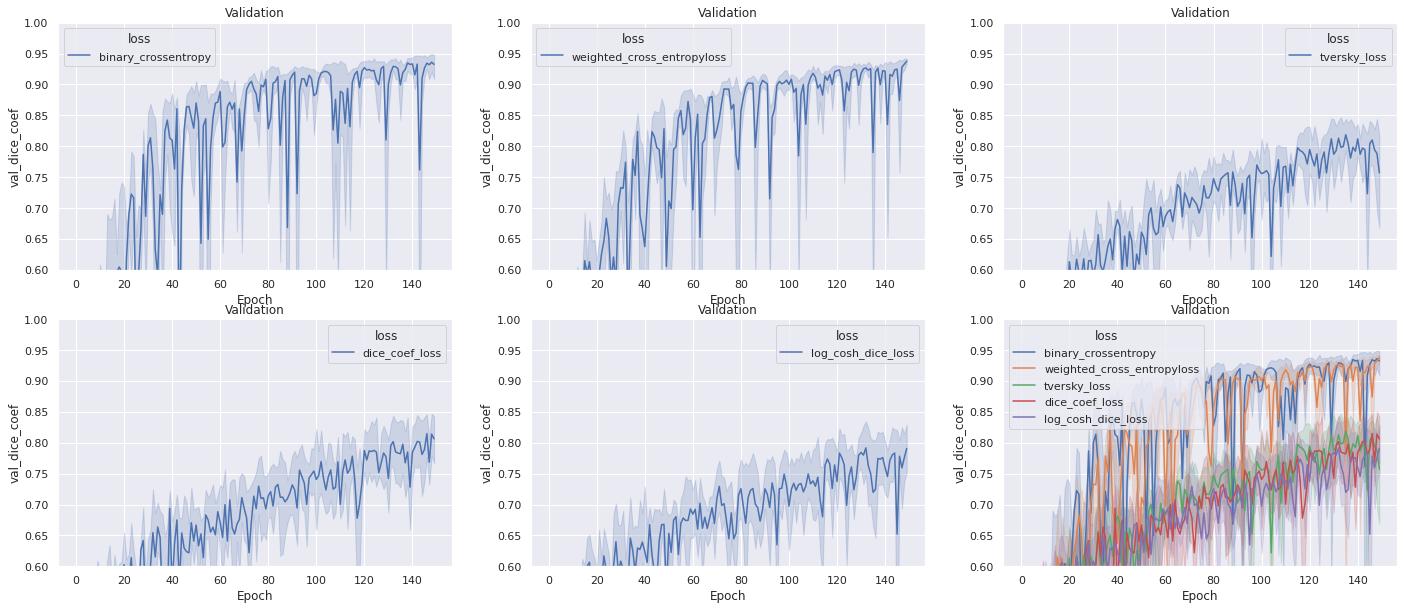

In [ ]:
frame=plot_trainings('unet_resnext101', ele='val_dice_coef', title='Validation')
plt.savefig(fig+'Validation-resnext101.svg')

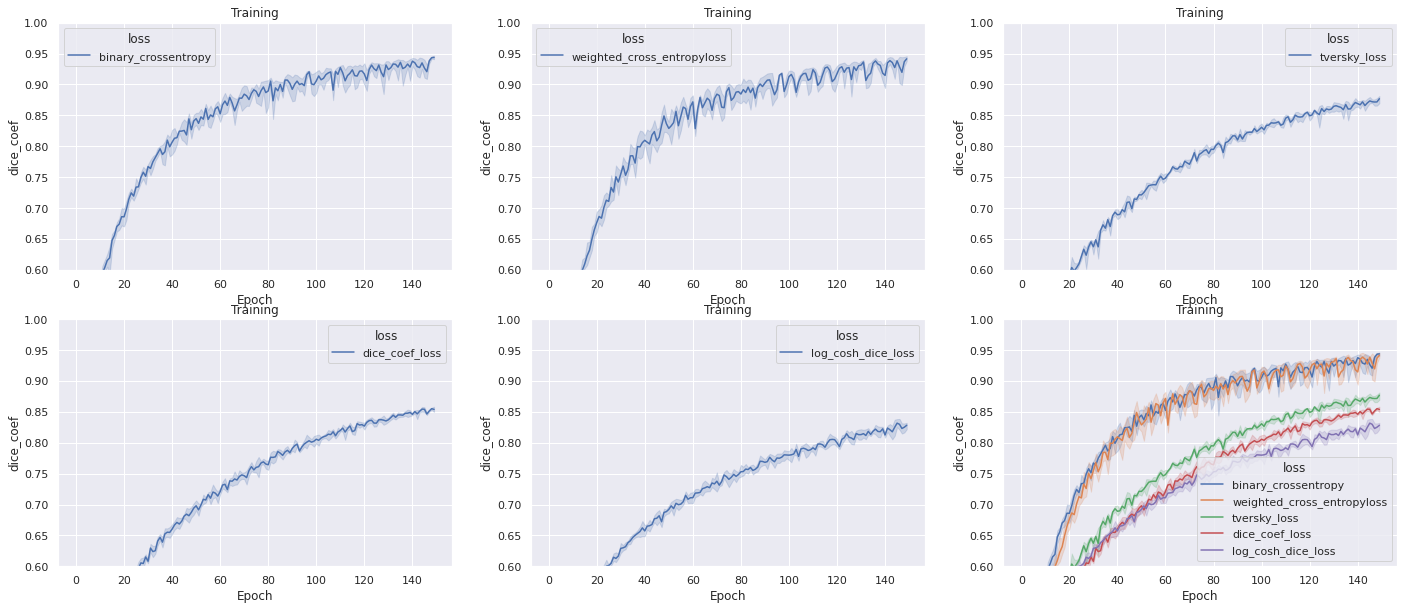

In [ ]:
frame=plot_trainings('unet_mobilenetv2', title='Training')
plt.savefig(fig+'Training-mobilenetv2.svg')

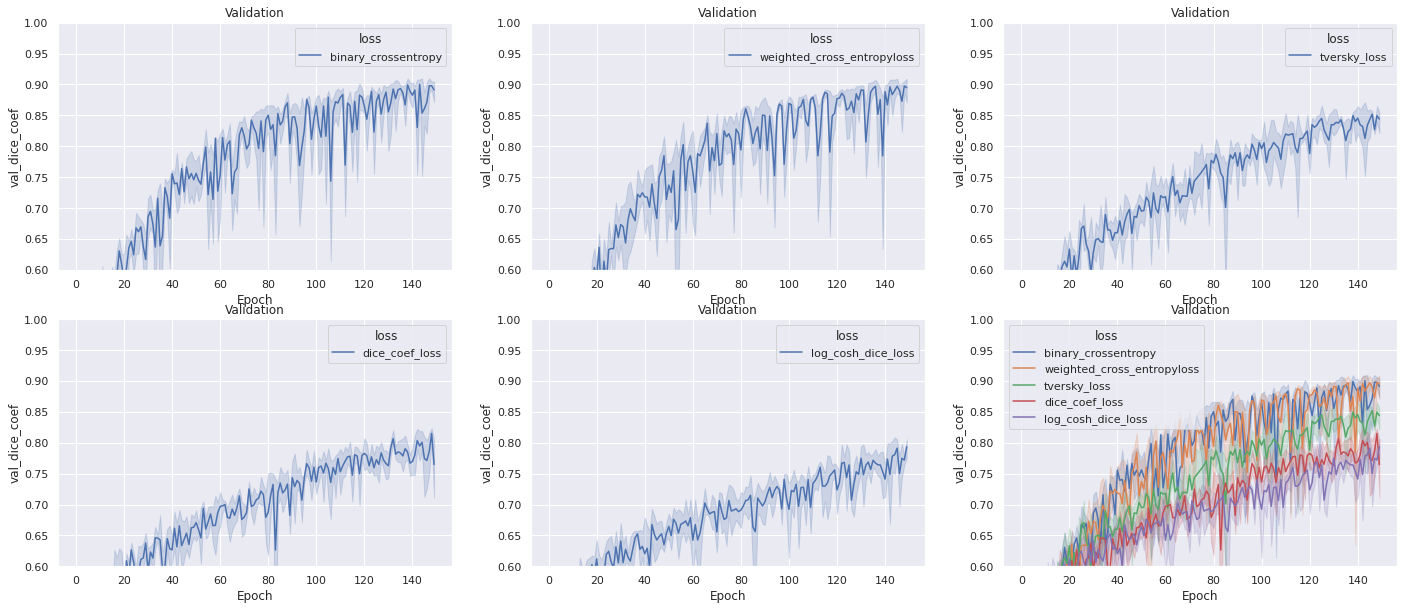

In [ ]:
frame=plot_trainings('unet_mobilenetv2', ele='val_dice_coef', title='Validation')
plt.savefig(fig+'Validation-mobilenetv2.svg')

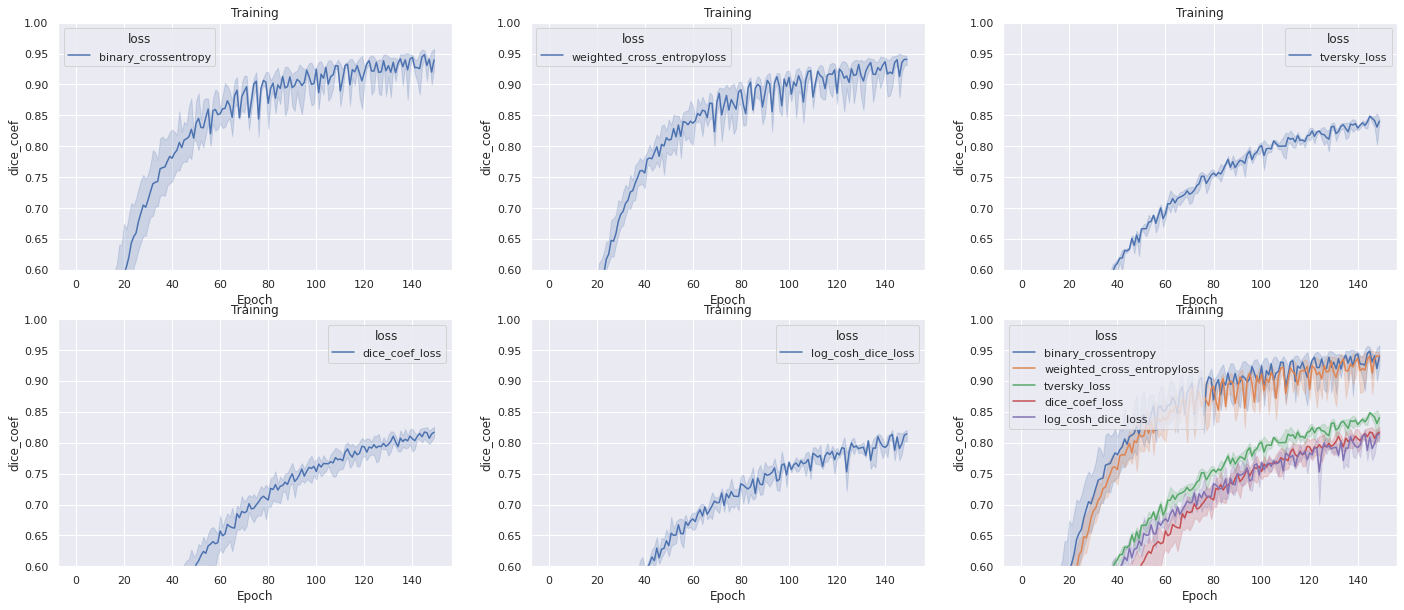

In [ ]:
frame=plot_trainings('link_vgg19', title='Training')
plt.savefig(fig+'Training-link_vgg19.svg')

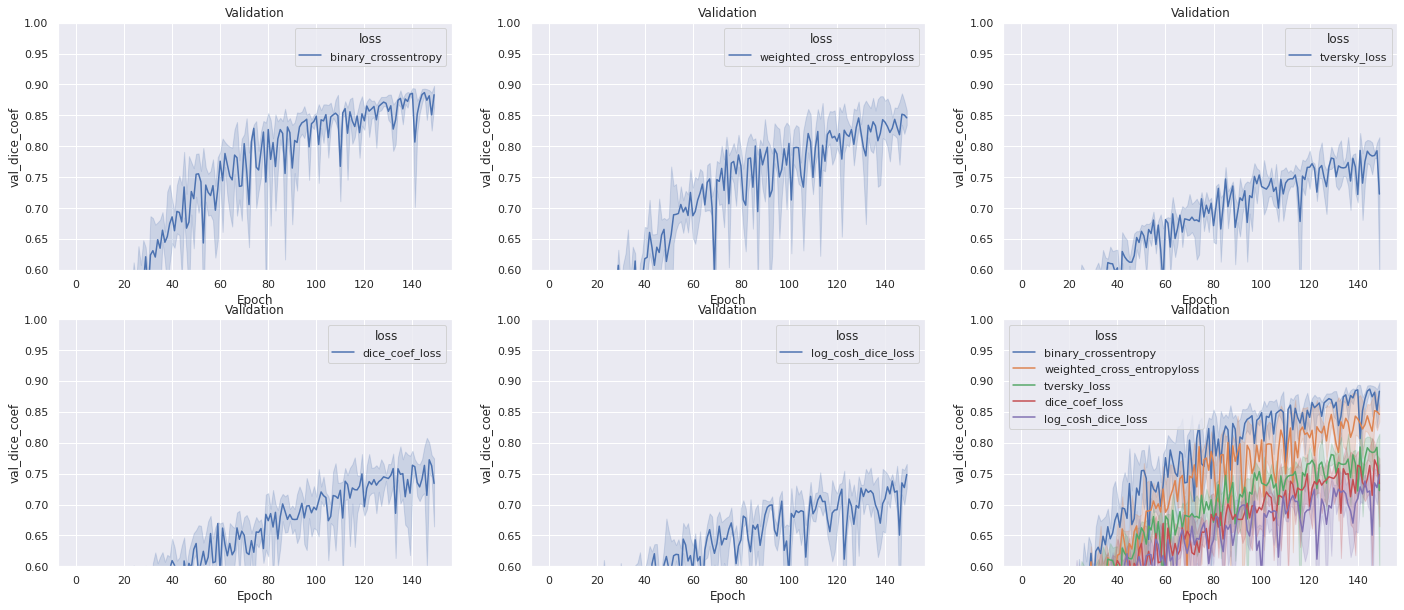

In [ ]:
frame=plot_trainings('link_vgg19', ele='val_dice_coef', title='Validation')
plt.savefig(fig+'Validation-link_vgg19.svg')

In [ ]:
frame=plot_trainings('multiresunet_vgg19', title='Training')
plt.savefig(fig+'Training-multiresunet.svg')

In [ ]:
frame=plot_trainings('multiresunet_vgg19', ele='val_dice_coef', title='Validation')
plt.savefig(fig+'Validation-multiresunet.svg')

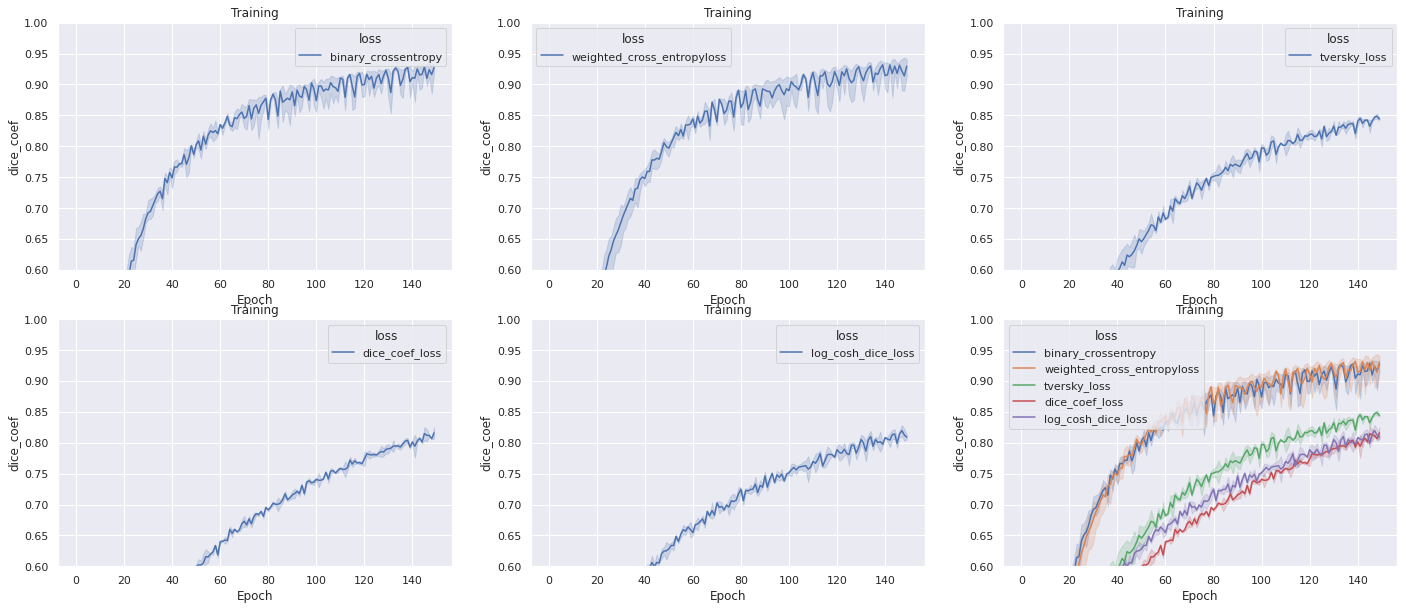

In [ ]:
frame=plot_trainings('unet_vgg19', title='Training')
plt.savefig(fig+'Training-vgg19.svg')

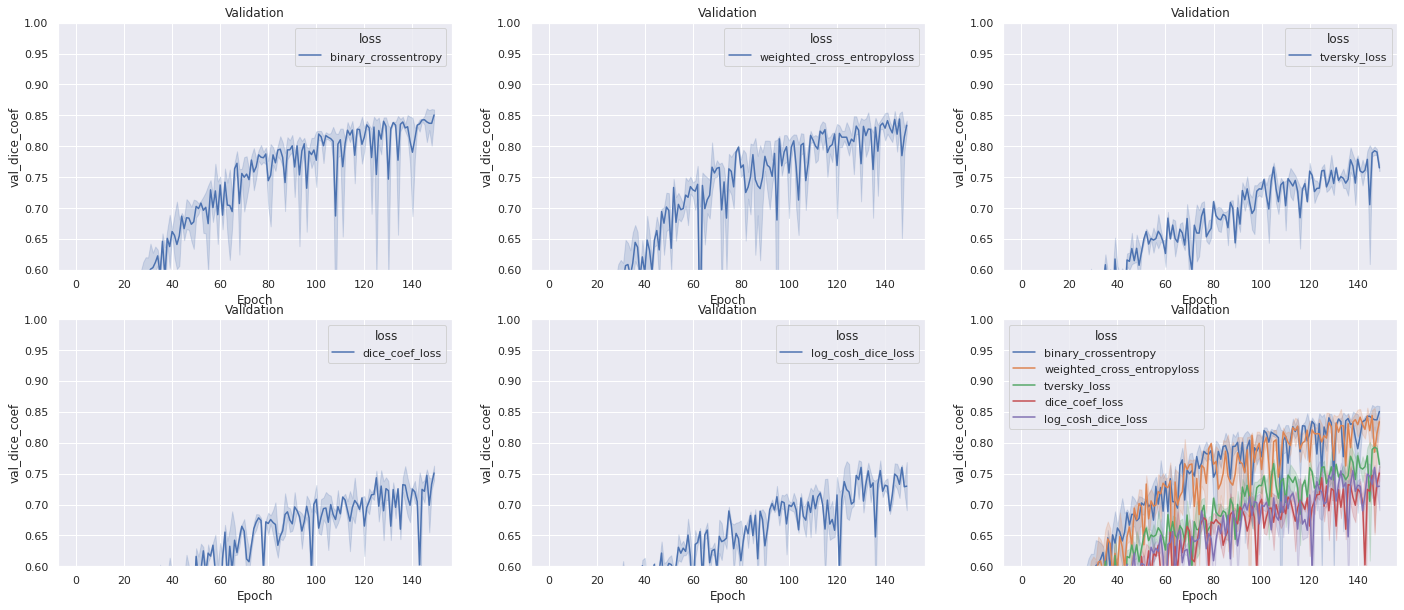

In [ ]:
frame=plot_trainings('unet_vgg19', ele='val_dice_coef', title='Validation')
plt.savefig(fig+'Validation-vgg19.svg')

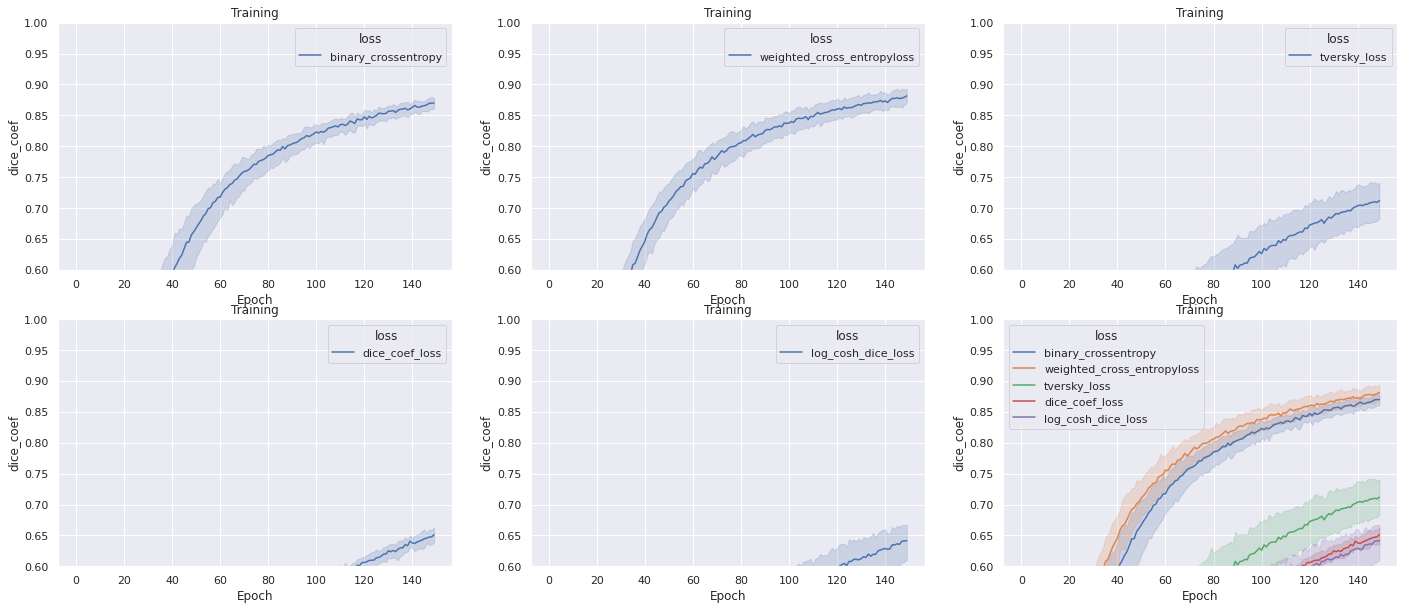

In [ ]:
frame=plot_trainings('Base_unet_None', title='Training')
plt.savefig(fig+'Training-base.svg')

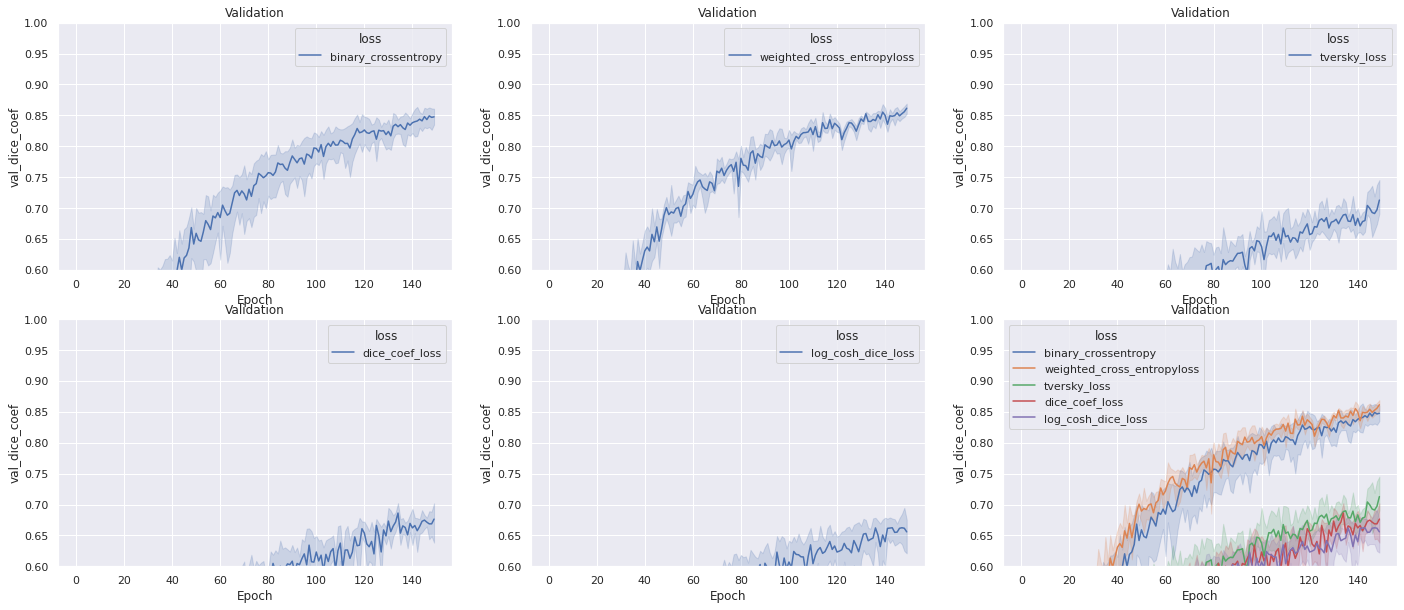

In [ ]:
frame=plot_trainings('Base_unet_None', ele='val_dice_coef', title='Validation')
plt.savefig(fig+'Validation-base.svg')

In [ ]:
frame=plot_trainings('unet_seresnet152', title='Training')
plt.savefig(fig+'Training-seresnet152.svg')

frame=plot_trainings('Base_unet_None', ele='val_dice_coef', title='Validation')
plt.savefig(fig+'Validation-seresnet152.svg')

In [ ]:
frame=plot_trainings('unet_seresnext101', title='Training')
plt.savefig(fig+'Training-seresnext101.svg')

frame=plot_trainings('unet_seresnext101', ele='val_dice_coef', title='Validation')
plt.savefig(fig+'Validation-seresnext101.svg')

### boxplot

In [ ]:
r_net={'unet_efficientnetb7': 'Efficient\nNet',
        'unet_seresnext101': 'SEResNeXt',
        'unet_seresnet152': 'SEResNet',
        'unet_inceptionresnetv2': 'Inception\nResNetV2',
        'multiresunet_vgg19': 'MultiRes\nUNet',
        'unet_resnet152': 'ResNet',
        'unet_mobilenetv2': 'Mobile\nNetV2',
        'unet_resnext101': 'ResNeXt',
        'unet_densenet201': 'Dense\nNet',
        'unet_vgg19': 'VGG19',
        'link_vgg19': 'LinkNet\nVGG19',
        'Base_unet_None': 'Base_UNet',
        'none': 'Efficient\nNet'}

In [ ]:
r_net={'unet_efficientnetb7': 'EfficientNet',
        'unet_seresnext101': 'SEResNeXt',
        'unet_seresnet152': 'SEResNet',
        'unet_inceptionresnetv2': 'InceptionResNetV2',
        'multiresunet_vgg19': 'MultiResUNet',
        'unet_resnet152': 'ResNet',
        'unet_mobilenetv2': 'MobileNetV2',
        'unet_resnext101': 'ResNeXt',
        'unet_densenet201': 'DenseNet',
        'unet_vgg19': 'VGG19',
        'link_vgg19': 'LinkNetVGG19',
        'Base_unet_None': 'Base_UNet',
        'none': 'EfficientNet'}

graphic


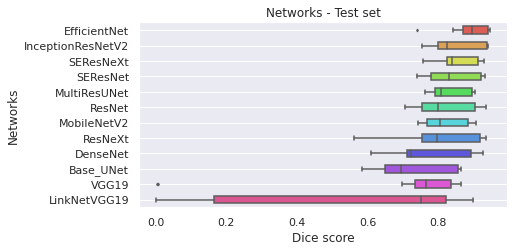

In [ ]:
order=list(df[["network", "dice_coef", "sensitivity", "specificity"]].groupby("network").describe().sort_values(by=[('dice_coef',   'mean')], ascending=False).index)
orde=[]
for i in order:
  orde=np.append(orde, r_net[i])
orde=list(orde)

sns.set(rc={'figure.figsize':(6.6, 3.4)})
sns.set_theme(style="darkgrid")
sns.boxplot(y="network", x="dice_coef", data=df, order=order, palette='hls', width=0.5, saturation=1, fliersize=2)
plt.yticks(ticks=np.arange(len(orde)), labels=orde, multialignment='right')
plt.title('Networks - Test set')
plt.ylabel('Networks')
plt.xlabel('Dice score')
plt.grid()
print('graphic')
plt.savefig('Dice score.svg')
#Multiplicar por 0.4797089917
#|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||#####|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

graphic


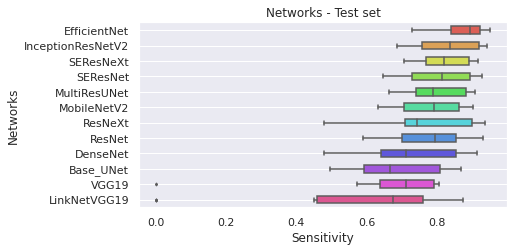

In [ ]:
order=list(df[["network", "dice_coef", "sensitivity", "specificity"]].groupby("network").describe().sort_values(by=[('sensitivity',   'mean')], ascending=False).index)
orde=[]
for i in order:
  orde=np.append(orde, r_net[i])
orde=list(orde)

sns.set(rc={'figure.figsize':(6.6, 3.4)})
sns.set_theme(style="darkgrid")
sns.boxplot(y="network", x="sensitivity", data=df, order=order, palette='hls', width=0.5, saturation=1, fliersize=2)
plt.yticks(ticks=np.arange(len(orde)), labels=orde, multialignment='right')
plt.title('Networks - Test set')
plt.ylabel('Networks')
plt.xlabel('Sensitivity')
plt.grid()
print('graphic')
plt.savefig('Sensitivity.svg')
#Multiplicar por 0.4797089917
#|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||#####|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

graphic


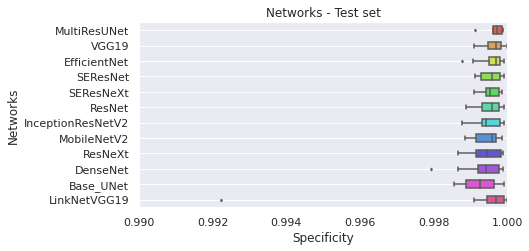

In [ ]:
order=list(df[["network", "dice_coef", "sensitivity", "specificity"]].groupby("network").describe().sort_values(by=[('specificity',   'mean')], ascending=False).index)
orde=[]
for i in order:
  orde=np.append(orde, r_net[i])
orde=list(orde)

sns.set(rc={'figure.figsize':(6.6, 3.4)})
sns.set_theme(style="darkgrid")
sns.boxplot(y="network", x="specificity", data=df, order=order, palette='hls', width=0.5, saturation=1, fliersize=2)
plt.yticks(ticks=np.arange(len(orde)), labels=orde, multialignment='right')
plt.title('Networks - Test set')
plt.ylabel('Networks')
plt.xlabel('Specificity')
plt.grid()
print('graphic')
plt.xlim((0.99, 1))
plt.savefig('Specificity.svg')
#Multiplicar por 0.4797089917
#|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||#####|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

graphic


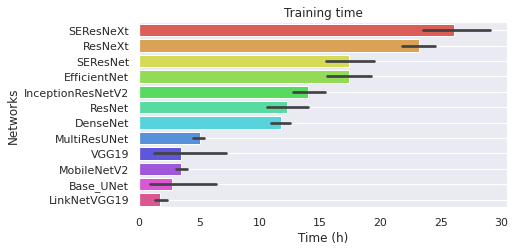

In [ ]:
order=list(df[["network", "dice_coef", "sensitivity", "specificity", "time"]].groupby("network").describe().sort_values(by=[('time',   'mean')], ascending=False).index)
orde=[]
for i in order:
  orde=np.append(orde, r_net[i])
orde=list(orde)

sns.set(rc={'figure.figsize':(6.6, 3.4)})
sns.set_theme(style="darkgrid")
sns.barplot(y="network", x="time", data=df, order=order, palette='hls', saturation=1)
plt.yticks(ticks=np.arange(len(orde)), labels=orde, multialignment='right')
plt.title('Training time')
plt.ylabel('Networks')
plt.xlabel('Time (h)')
plt.grid()
print('graphic')
plt.savefig('trainingtime.svg')
#plt.savefig('Specificity.svg')
#Multiplicar por 0.4797089917
#|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||#####|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

graphic


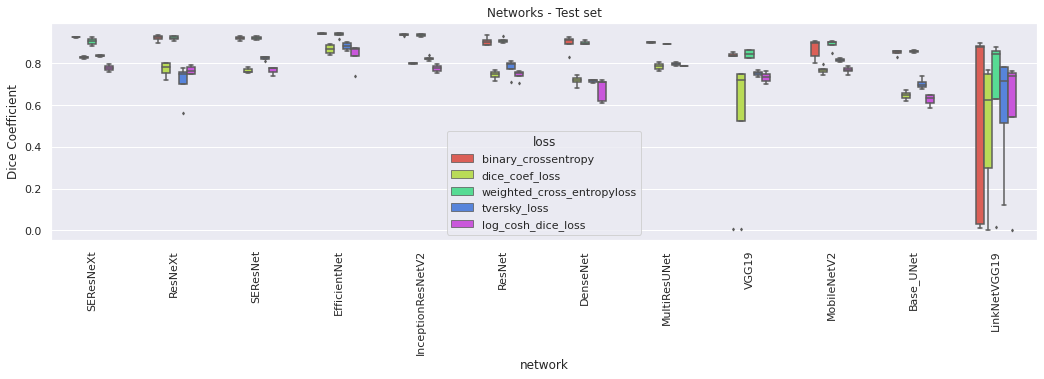

In [ ]:
sns.set(rc={'figure.figsize':(17.67,4)})
sns.set_theme(style="darkgrid")
sns.boxplot(x="network", y="dice_coef", hue='loss', data=df, order=order, palette='hls', width=0.5, saturation=1, fliersize=2)
plt.xticks(ticks=np.arange(len(orde)), labels=orde, rotation='vertical', multialignment='right')
plt.title('Networks - Test set')
plt.ylabel('Dice Coefficient')
print('graphic')
plt.savefig('losses.svg')
#Multiplicar por 0.4797089917
#|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||#####|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [ ]:
real_n={'binary_crossentropy': 'Binary\nCross\nentropy',
        'weighted_cross_entropyloss': 'Weighted\nCross\nentropy',
        'tversky_loss': 'Focal\nTversky',
        'dice_coef_loss': 'Dice\nCoefficient\nLoss',
        'log_cosh_dice_loss': 'Log-Cosh\nDice'}

In [ ]:
order2=list(df[["loss", "dice_coef", "sensitivity", "specificity"]].groupby("loss").describe().sort_values(by=[('dice_coef',   'max')], ascending=False).index)

In [ ]:
framex=pd.DataFrame(columns=['tumor_type','run_n', 'network', 'optimizer', 'loss', 'epochs', 'total_parameters', 'time','augm', 'result_mat', 'Metric', 'Score'])
for ix in ['dice_coef','sensitivity','specificity']:
  dicef=df[['tumor_type','run_n', 'network', 'optimizer', 'loss', 'epochs', 'total_parameters', 'time','augm', ix, 'result_mat']]
  dicef['Metric']=[ix for d in range(214)]
  dicef['Score']=dicef[ix]
  dicef.drop([ix], axis=1)
  dicef=dicef.drop(dicef.columns[:np.where(dicef.columns=='tumor_type')[0][0]], axis=1)  
  framex=framex.append(dicef, ignore_index=True)

In [ ]:
ord=[]
for i in order2:
  ord=np.append(ord, real_n[i])
ord=list(ord)

In [ ]:
sns.set(rc={'figure.figsize':(8.2, 3.4)})
sns.set_theme(style="darkgrid")
sns.boxplot(x="loss", y="Score", hue='Metric', data=framex, order=order2, palette='hls', width=0.3, saturation=1, fliersize=2)
plt.xticks(ticks=np.arange(len(ord)), labels=ord, rotation='vertical', multialignment='right')
plt.title('Losses - Test set')
plt.ylabel('Score')
plt.ylim((0.4))
print('graphic')
plt.savefig('losses.svg')
#Multiplicar por 0.4797089917
#|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||#####|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

### Otros

In [ ]:
times=pd.read_csv('/content/drive/MyDrive/INDIGO_MLR/CancerDeMama/figures/TIMES.csv')

In [ ]:
ord3=list(times[['Total time', 'Time per subject', 'Network']].groupby("Network").describe().sort_values(by=[('Total time', 'mean')]).index)

In [ ]:
ordx3=[]
for i in ord3:
  ordx3=np.append(ordx3, r_net[i])
ordx3=list(ordx3)

graphic


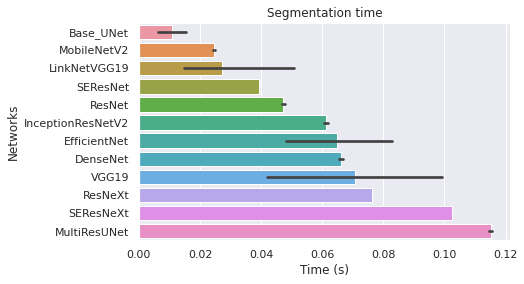

In [ ]:
sns.set(rc={'figure.figsize':(6.65, 4)})
sns.set_theme(style="darkgrid")
sns.barplot(y='Network', x='Time per subject', data=times, order=ord3)
plt.yticks(ticks=np.arange(len(ordx3)), labels=ordx3, multialignment='right')
plt.title('Segmentation time')
plt.ylabel('Networks')
plt.xlabel('Time (s)')
print('graphic')
plt.savefig('tiempos de prediccion.svg')
#Multiplicar por 0.4797089917
#|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||#####|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

### Size

In [ ]:
size_m=np.sum(np.sum(y_test[...,0], axis=1), axis=1)
indx=np.argsort(size_m)

...
tumor_type                                                         NaN
run_n                                                                2
network                                            unet_efficientnetb7
optimizer                                                         Adam
loss                                               binary_crossentropy
epochs                                                             150
total_parameters                                              75048097
time                                                           15.4186
augm                                                                 8
jaccard_distances                                          0.000515627
acc                                                           0.999573
sensitivity                                                   0.952149
specificity                                                   0.999811
FPR                                                        0.000189364
di

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


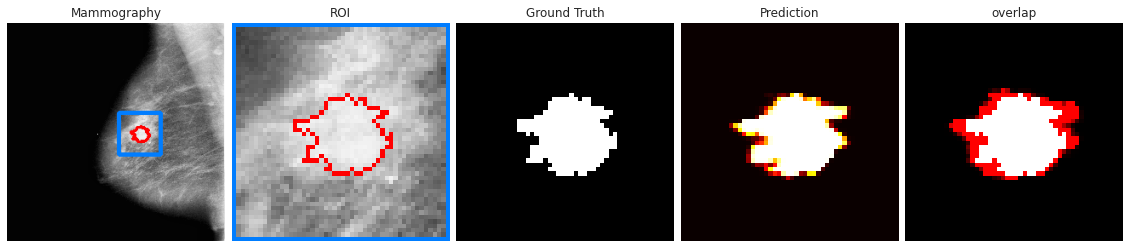

In [ ]:
y_hatB=test_model(df)
plot_threm(x_test, y_hatB, y_test)

...
tumor_type                                                         NaN
run_n                                                               11
network                                                 Base_unet_None
optimizer                                                         Adam
loss                                        weighted_cross_entropyloss
epochs                                                             150
total_parameters                                               1945521
time                                                          0.895547
augm                                                                 8
jaccard_distances                                           0.00122883
acc                                                           0.998957
sensitivity                                                   0.814257
specificity                                                   0.999881
FPR                                                        0.000118613
di

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


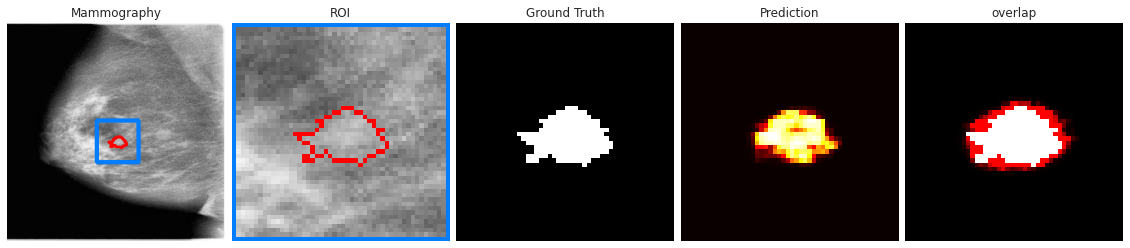

In [ ]:
y_hatW=test_model(df, 'Base_unet_None')
plot_threm(x_test, y_hatW, y_test)

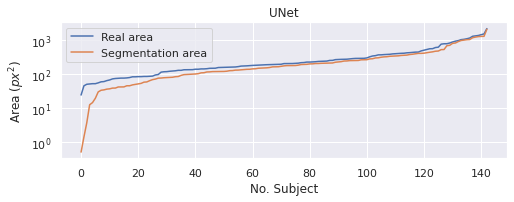

In [ ]:
size_hat=np.sum(np.sum(y_hatW[...,0], axis=1), axis=1)
hat=np.argsort(size_hat)

sns.set(rc={'figure.figsize':(8, 2.5)})
sns.set_theme(style="darkgrid")
plt.plot(size_m[indx])
plt.plot(size_hat[hat])
plt.title('UNet')
plt.legend(['Real area', 'Segmentation area'])
plt.xlabel('No. Subject')
plt.ylabel('Area ($px^2$)')
plt.yscale('log')
plt.savefig('unet-area.svg')
#Multiplicar por 0.4797089917
#|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||#####|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

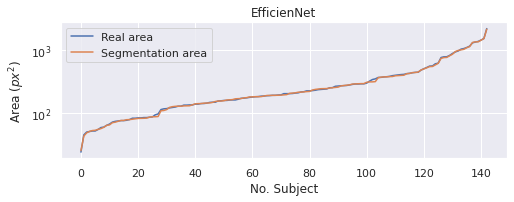

In [ ]:
size_hat=np.sum(np.sum(y_hatB[...,0], axis=1), axis=1)
hat=np.argsort(size_hat)

sns.set(rc={'figure.figsize':(8, 2.5)})
sns.set_theme(style="darkgrid")
plt.plot(size_m[indx])
plt.plot(size_hat[hat])
plt.legend(['Real area', 'Segmentation area'])
plt.title('EfficienNet')
plt.xlabel('No. Subject')
plt.ylabel('Area ($px^2$)')
plt.yscale('log')
plt.savefig('efficient_area.svg')
#Multiplicar por 0.4797089917
#|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||#####|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [ ]:
def dice_coef(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

In [ ]:
area=[]
dice=[]
dice_m=1
dice_mx=0
nn=[]
pos=0
posx=0
for n, i in enumerate(indx):
  dice=np.append(dice,float(dice_coef(y_test[i], y_hatB[i])))
  area=np.append(area, size_m[i])
  nn=np.append(nn,n)#size_m[i])
  if dice[-1]<dice_m:
    dice_m=dice[-1]
    pos=i
  if dice[-1]>dice_mx:
    dice_mx=dice[-1]
    posx=i 

In [ ]:
indx[115], indx[120]

(32, 38)

In [ ]:
np.where(dice>=0.98)

(array([115, 120]),)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


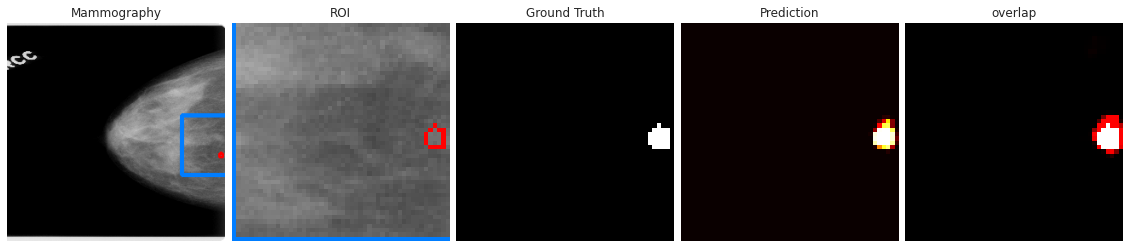

In [ ]:
#worst
px=40
plot_threm(x_test, y_hatB, y_test, px)
float(dice_coef(y_test[px], y_hatB[px]))
plt.savefig('0_8845623135566711.svg')

In [ ]:
indx

array([ 40,   0,  62,  24, 135,  94, 126,  23, 102,  26, 109, 140,  78,
        49,  16, 111, 118,  46,  27,  50, 130,  53,  70,  60,  52,  54,
        80, 141, 123,  99,  45, 138,  43,  68,  59,  84, 122,  14, 127,
         5,  13,  15, 104,  83, 134,  82,  81,  35,  88,  93, 125,  95,
       112,  34,  58, 119, 133,  97,   8, 114,   9,  69, 129, 128,  64,
        98,  75,  47, 132,  12,  48, 100,  77, 103,   3,  71, 136,  89,
        22,  51,  37, 101,  87, 139, 137,  79,  41,  42, 131,  11, 142,
        39, 107,  57,  96,  74,  17, 116, 105,  90, 124,  19, 106,  65,
        33,  31, 108,  21,  29,  67,  85,  76,  72, 110,  44,  32,  20,
        30,  10, 121,  38,  73,  28, 117,  92,   4, 120, 113,  66,  86,
        18,  36,  25,  91, 115,  56,   1,  61,   7,   6,  55,   2,  63])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


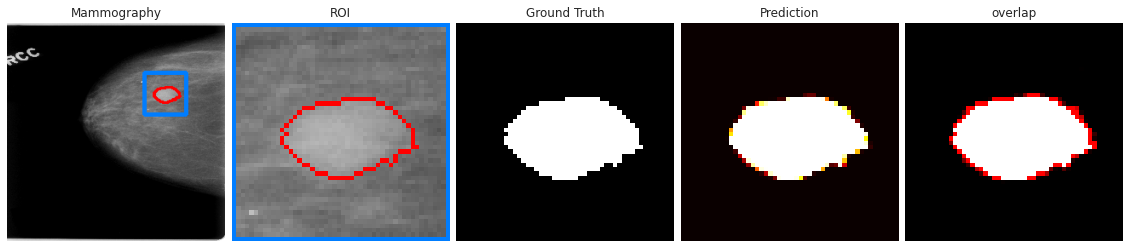

In [ ]:
#best
mx=32
plot_threm(x_test, y_hatB, y_test, mx)
float(dice_coef(y_test[mx], y_hatB[mx]))
plt.savefig('0_9801031351089478.svg')

In [ ]:
df3=pd.DataFrame({'subject':nn,'Dice':dice, 'Area':area})

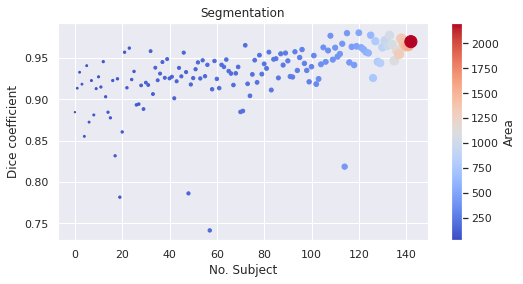

In [ ]:
sns.set(rc={'figure.figsize':(8.28,4)})
plt.scatter('subject', 'Dice', c = 'Area', s=area/15, cmap='coolwarm', data=df3)
plt.title('Segmentation')
plt.xlabel('No. Subject')
plt.ylabel('Dice coefficient')
plt.colorbar(label="Area")
plt.savefig('por tamano.svg')
#Multiplicar por 0.4797089917
#|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||#####|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||